In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import load_npz,save_npz
import datetime
import re
import matplotlib.pyplot as plt
from glob import glob
from missingno import matrix
from pyproj import Transformer
from IPython.display import display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
import wandb

import os

os.environ["WANDB_SILENT"] = "True"
wandb.login()

True

In [2]:
# URLS
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
URL_gauge_2020_file = URL_gauge_data + 'clean2020data1475.csv'
URL_saved_sensor_data = URL_gauge_data + 'hbs_lysigogn.csv'
DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
DIR_rain_gauges = glob(URL_gauge_data + '*cleaned*')

In [20]:
# Rain gauge metadata
df_sensors = pd.read_csv(URL_saved_sensor_data, sep='\t', encoding='Windows-1252')
## Raw rain gauge data
rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
gauges_raw = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T
gauges_raw = gauges_raw.loc[:,['1473','1475','1481','1485']]
gauges_raw_hour = gauges_raw.resample('1h').agg(pd.Series.sum, skipna=False)
# Processed rain gauge data
gauges_clean_long = pd.read_csv(URL_gauge_data + 'yfirfarid_hbs.csv',sep='\t')
gauges_clean_long.TIMI = pd.to_datetime(gauges_clean_long.TIMI)
gauges_clean = gauges_clean_long.pivot_table(values='R',index='TIMI',columns='STOD')
gauges_clean.columns = [str(i) + '_clean' for i in gauges_clean.columns]
# All rain gauge data 
gauges = pd.concat([gauges_raw_hour,gauges_clean],axis=1)

# Drainage flow data
df_target = pd.read_pickle('../../Drainage data/all_drainage_data_uncorrected.pkl')

<AxesSubplot:>

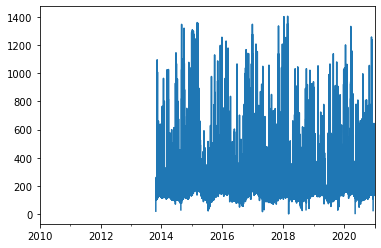

In [21]:
df_target.loc[:,'RVK-GEL'].plot()

In [4]:
# Replace all 0 with nan, drop all nan, reindex and then fill nan with 0 (Cuts away all the 0 from the start)
full_index = pd.date_range(gauges_raw_hour.index.min(),gauges.index.max(),freq='1h')
processed_gauges = gauges.copy()
for gauge in gauges:
    first_non_zero_index = processed_gauges.loc[:,gauge].mask(lambda x : x == 0).first_valid_index()
    processed_gauges.loc[:first_non_zero_index,gauge] = np.nan
    # plt.plot(processed_gauges.loc[:,gauge])
    # plt.title(gauge)
    # plt.show()

In [6]:
# tmp_results = pair_lag_correlations(gauges.loc[:,'1475'],df_target.loc[:,'RVK-BOD'],lag_values)
# plt.plot(tmp_results)

# Inter-rain gauge correlation

In [7]:
# lag_values = range(-20,20)
# gauge_corr = {}
# gauge_names = processed_gauges.columns
# gauge_pairs_corr = {a:{b:None for b in gauge_names} for a in gauge_names}
# for a in gauge_pairs_corr:
#     for b in gauge_pairs_corr[a]:
#         A = processed_gauges.loc[:,a]
#         B = processed_gauges.loc[:,b]
#         gauge_pairs_corr[a][b] = pair_lag_correlations(A,B,lag_values)
# df_gauge_corrs = pd.DataFrame(gauge_pairs_corr)

In [8]:
# len(sensor_coords),len(df_sensors)

In [9]:
# transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
# transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit
# sensor_coords = [transformer_gps_isl.transform(b,a) for a,b in zip(df_sensors.BREIDD_Y,df_sensors.LENGD_X)]
# sensor_coords = np.array(sensor_coords)
# df_sensors.loc[:,'gpsx'] = sensor_coords[:,0]
# df_sensors.loc[:,'gpsy'] = sensor_coords[:,1]

In [10]:
# x_in_y = lambda x,y : len(re.findall(f'{x}.*',y)) > 0
# dist_corr = []
# for key1 in gauge_pairs_corr:
#     bool_idx = df_sensors.loc[:,'STOD'].apply(lambda x : x_in_y(x,key1))
#     gps1 = df_sensors.loc[bool_idx,'gpsx'].apply(np.array),df_sensors.loc[bool_idx,'gpsy']
#     gps1 = np.array(gps1).squeeze()
#     for key2 in gauge_pairs_corr:
#         bool_idy = df_sensors.loc[:,'STOD'].apply(lambda x : x_in_y(x,key2))
#         gps2 = df_sensors.loc[bool_idy,'gpsx'],df_sensors.loc[bool_idy,'gpsy']
#         gps2 = np.array(gps2).squeeze()
#         distance = ((gps1 - gps2)**2).sum()**0.5
#         correlation = gauge_pairs_corr[key1][key2]
#         # if (('clean' in key1) and ('clean' in key2)):
#         dist_corr.append((key1,key2,distance,correlation))
# df_dist_corr = pd.DataFrame(dist_corr,columns = ['gauge1','gauge2','distance','correlation'])
# df_dist_corr.loc[:,'max_corr'] = df_dist_corr.correlation.apply(max)

In [11]:
# slope = lambda a : np.linalg.lstsq(np.hstack([a.loc[:,'distance'].values.reshape(-1,1),
#                                               np.ones(len(a)).reshape(-1,1)]),
#                                    a.loc[:,'max_corr'].values.reshape(-1,1),
#                                    rcond=None)[0][:,0]
# slope_func = lambda x : (lambda a : x[0] * a + x[1])
# plot_slope = lambda x : plt.plot([0,50_000],
#                                  [slope_func(x)(0),
#                                   slope_func(x)(50_000)])

# plt.figure(figsize=(14,5))
# df_dist_corr.groupby('gauge1').apply(slope).apply(plot_slope)
# df_dist_corr.groupby('gauge1').apply(lambda x : plt.scatter(x.loc[:,'distance'] + np.random.normal(0,1000,len(x)),
#                                                             x.loc[:,'max_corr'] + np.random.normal(0,0.08,len(x))))
# plt.legend(df_dist_corr.loc[:,'gauge1'].value_counts().index)
# # plt.ylim(-0.1,1.1)
# plt.show()

In [12]:
# correct_order = []
# for n1,n2 in zip(df_dist_corr.loc[:,'gauge1'].values,df_dist_corr.loc[:,'gauge2'].values):
#     correct_order.append(sorted([n1,n2]))
# correct_order = np.array(correct_order)
# df_dist_corr_order = df_dist_corr.copy()
# df_dist_corr_order.loc[:,'gauge1'] = correct_order[:,0]
# df_dist_corr_order.loc[:,'gauge2'] = correct_order[:,1]
# unique_index = df_dist_corr_order.iloc[:,:-2].drop_duplicates().index 
# df_dist_corr_order = df_dist_corr_order.loc[unique_index]

# plt.figure(figsize=(14,5))
# plt.scatter(df_dist_corr_order.loc[:,'distance'],df_dist_corr_order.loc[:,'correlation'].apply(max))
# for n1,n2,d,_,c in df_dist_corr_order.values:
#     plt.text(d,np.max(c),n1 + '-' + n2)
    
    
# plt.ylabel('Correlation')
# plt.xlabel('Distance between rain gauges')
# plt.title('Distance correlation relationship of raingauges')

# Rain gauge - drainage correlation

This is a list
- item 1
- item 2


In [10]:
lag_values = range(-20,20)
corr_dict = {}
for drainage_name in df_target.columns:
    print(drainage_name)
    tmp_dict = {}
    for gauge_name in processed_gauges.columns:
        X_tmp = processed_gauges.loc[:,gauge_name]
        Y_tmp = df_target.loc[:,drainage_name]
        tmp_dict[gauge_name] = pair_lag_correlations(X_tmp,Y_tmp,lag_values)
    corr_dict[drainage_name] = tmp_dict

# this is just for a dict that can be turned into a dataframe
df_corr_all = pd.DataFrame(corr_dict)

RVK-SEI
RVK-BOD
RVK-VES
KOP-HAB
RVK-SKE
RVK-FAX
RVK-ANA
MOS-HOL


C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


RVK-ING
RVK-LAU
RVK-GUF
RVK-GEL
RVK-KLE


# Selecting the subeset of data for which other weather observations are available

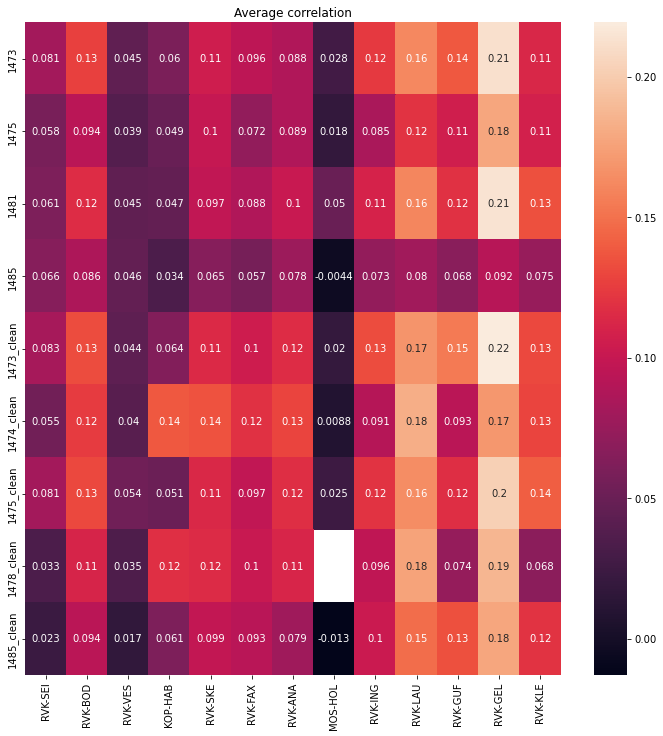

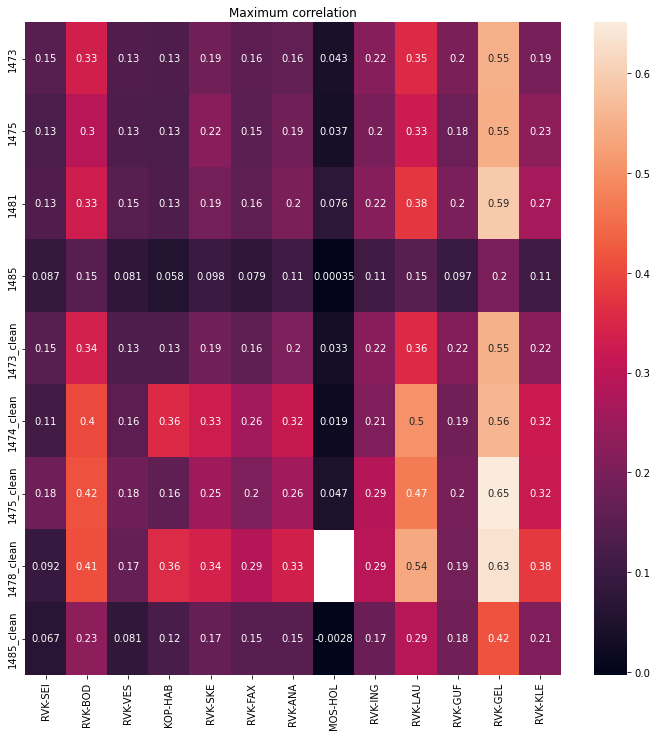

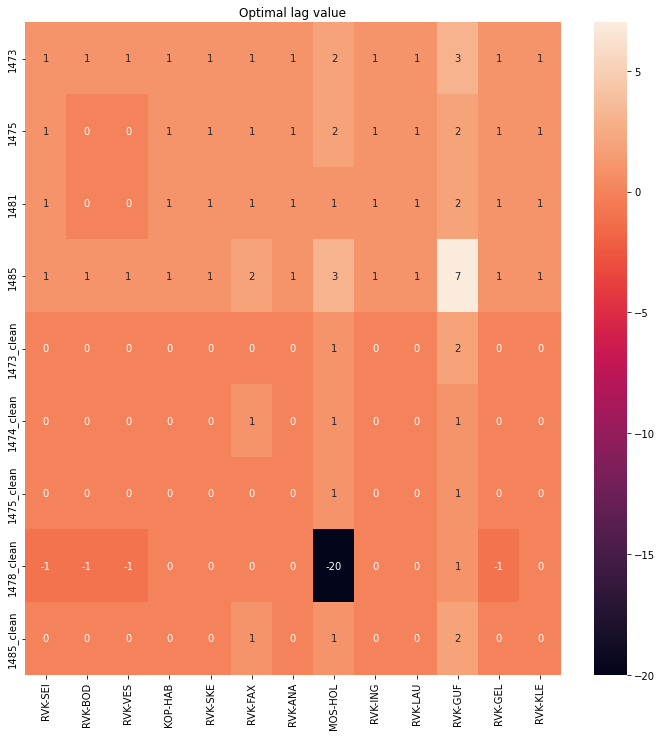

In [11]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(df_corr_all.applymap(np.mean),annot=True)
plt.title('Average correlation')
plt.show()

plt.figure(figsize=(12,12))
sns.heatmap(df_corr_all.applymap(np.max),annot=True)
plt.title('Maximum correlation')
plt.show()

plt.figure(figsize=(12,12))
sns.heatmap(df_corr_all.applymap(lambda x : int(lag_values[np.argmax(x)])),annot=True)
plt.title('Optimal lag value')
plt.show()


# Let's use 1473 to predict for GEL


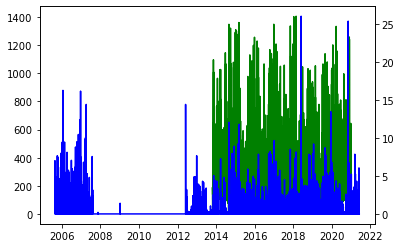

In [12]:
plt.plot(df_target.loc[:,'RVK-GEL'],color='green')
plt.twinx().plot(gauges.loc[:,'1473'],color='blue')

# drainage_sensor = 'RVK-BOD'
# rain_gauge = '1475_clean'
# plt.plot(df_target.loc[:,drainage_sensor],color='green')
# plt.twinx().plot(processed_gauges.loc[:,rain_gauge],color='blue')

In [13]:
import tensorflow as tf
import tensorflow_probability as tfp
from numpy.lib.stride_tricks import sliding_window_view


In [14]:
# Model
lag = 168

def get_x_y_with_lag(lag,
                     input_data = gauges.loc[:,'1473'].resample('1h').sum(),
                     output_data = df_target.loc[:,'RVK-GEL'].resample('1h').sum(),
                     dt_start = datetime.datetime(2014,1,1,0,0,0),
                     dt_end = datetime.datetime(2020,12,31,23,59,59)):
    
    new_index = pd.date_range(dt_start,dt_end, freq='1h')
    common_index = input_data.index.intersection(output_data.index)
    
    # remove missing data
    input_data = input_data.loc[common_index]
    output_data = output_data.loc[common_index]
    input_data = input_data.dropna()
    output_data = output_data.dropna()
    # Replace with nan values in both datasets
    input_data = input_data.reindex(new_index)
    output_data = output_data.reindex(new_index)

    # Sliding window
    output_sequences = sliding_window_view(output_data,(lag)).squeeze()[:,-1]
    if (len(input_data.shape) == 1) or (input_data.shape[-1] == 1):
        rainfall_input_sequences = sliding_window_view(input_data,(lag)).reshape((-1,lag))
    else:
        rainfall_input_sequences = sliding_window_view(input_data,(lag,input_data.shape[-1])).reshape((-1,lag,input_data.shape[-1]))

    return rainfall_input_sequences,output_sequences.reshape(-1,1)


In [16]:
# cycle_length = 24
# remove_cycle = lambda x,c : (np.nanmax([x[c],0]) + (x.diff(c).cumsum()/c).shift(-c))
# remove_season = lambda x : x - x.rolling(24*7*2,min_periods = 0).min()

Xg = processed_gauges.loc[:,'1473'].resample('1h').sum()
Xw = pd.read_pickle('../../Rainfall - runoff/input_data').loc[:,['temperature','radiation','moist_pressure']]
X = pd.concat([Xw,Xg],axis=1).dropna()
Y = df_target.loc[:,'RVK-GEL'].resample('1h').sum()

lag = 168*2
input_sequences,output_sequences =\
    get_x_y_with_lag(lag,
                     input_data = X,
                     output_data = Y,
                     dt_start = X.index.min(),
                     dt_end = datetime.datetime(2020,12,31,23,59,59))

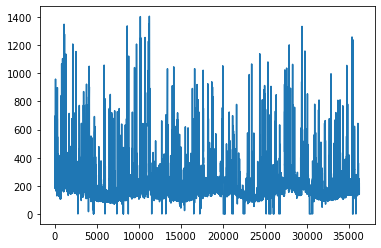

In [19]:
plt.plot(output_sequences)

# Comparing rainfall-runoff models

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.svm import SVR
from sklearn.linear_model import *

# Standardized evaluation procedure

In [160]:
# for i,(test,train) in enumerate(dataset):
#     print(i,test,train)


In [81]:
from sklearn.model_selection import KFold,TimeSeriesSplit

def evaluate_model(model,
                   params = [0,1,2,3],
                   lag = 100000,
                   squeeze = True,
                   model_constructor = None,
                   specify_validation_data = False,
                   fn_kfold = KFold,
                   folds = 5,
                   multiple_inputs = False,
                   **kwargs):
    if type(dataset) != type(None):
        raise Exception('You havent implemented this yet!')
    
    model_list = []
    history = {}
    y_test_preds = []
    
    kfold = fn_kfold(folds)
    if multiple_inputs:
        
    else:
        input_data = input_sequences[:,-lag:,params]
        
    if squeeze:
        input_data = input_data.reshape((len(output_sequences),-1))
        
    for i,(train, test) in enumerate(kfold.split(input_data,output_sequences)):
        fold_history = {}
        X_train = input_data[train]
        Y_train = output_sequences[train]
        X_test = input_data[test]
        Y_test = output_sequences[test]
        # If the model needs to be reconstructed
        if not isinstance(model_constructor,type(None)):
            model = model_constructor()
            
        if specify_validation_data:
            model.fit(X_train,
                      Y_train,
                      validation_data = (X_test,
                                         Y_test),**kwargs)
        else:
            model.fit(X_train, output_sequences[train],**kwargs)
        
        y_train_pred = model.predict(X_train).ravel()
        y_test_pred = model.predict(X_test).ravel()
        
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        
        fold_history['mse_train'] = tf.losses.MSE(Y_train,y_train_pred).numpy()
        fold_history['mse_test'] = tf.losses.MSE(Y_test,y_test_pred).numpy()
        fold_history['mae_train'] = tf.keras.metrics.MAE(Y_train,y_train_pred).numpy()
        fold_history['mae_test'] = tf.keras.metrics.MAE(Y_train,y_train_pred).numpy()
        
        model_list.append(model)
        
        history[i] = fold_history
        y_test_preds.append(y_test_pred)
    return (history,model_list,np.concatenate(y_test_preds).ravel())




# Linear regression model on lagged values


In [22]:
history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(), params = 3)
df_history_linreg = pd.DataFrame(history_dict_linreg).T

In [23]:
def visualize_perforamnce_and_events(y_pred_test):
    rain_ids = [
        input_sequences[:,-1,-1].argmax(),
        output_sequences.argmax(),
        y_pred_test.argmax(),
    ]


    plt.figure(figsize=(15,4))
    plt.plot(output_sequences)
    plt.plot(y_pred_test)
    plt.vlines(rain_ids,-100,np.max(y_pred_test),color='red',linestyle = 'dotted')
    plt.show()

    buff = 168
    
    f,axes = plt.subplots(1,len(rain_ids),figsize=(15,4))
    for rainevent,ax in zip(rain_ids,axes.ravel()):
        i_start = rainevent - buff
        i_end = rainevent + buff
        ax.plot(output_sequences[i_start:i_end])
        ax.plot(y_pred_test[i_start:i_end])
        ax.legend(['True','Predicted'])
    plt.show()
        

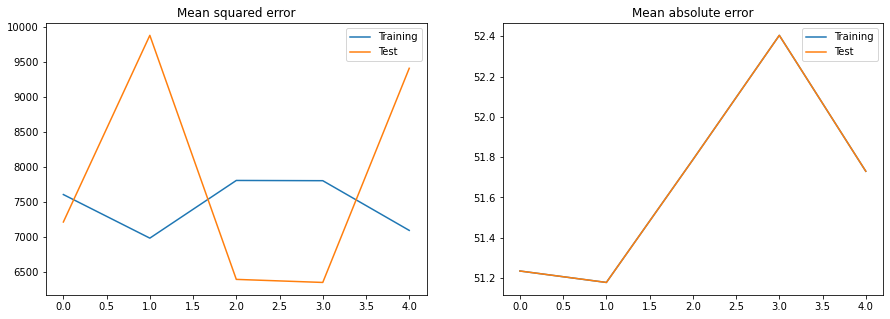

In [24]:
def visualize_history_dict(history_tmp):
    f,axes = plt.subplots(1,2,figsize=(15,5))
    history_tmp.loc[:,'mse_train'].plot(ax = axes[0])
    history_tmp.loc[:,'mse_test'].plot(ax = axes[0])
    axes[0].set_title('Mean squared error')
    axes[0].legend(['Training','Test'])
    
    history_tmp.loc[:,'mae_train'].plot(ax = axes[1])
    history_tmp.loc[:,'mae_test'].plot(ax = axes[1])
    ax = axes[1].set_title('Mean absolute error')
    ax = axes[1].legend(['Training','Test'])


    # history_tmp.loc[:,'corr_train'].plot(ax = axes[2])
    # history_tmp.loc[:,'corr_test'].plot(ax = axes[2])
    # ax = axes[2].set_title('Correlation')
    # ax = axes[2].legend(['Training','Test'])
    plt.show()
        
visualize_history_dict(df_history_linreg)


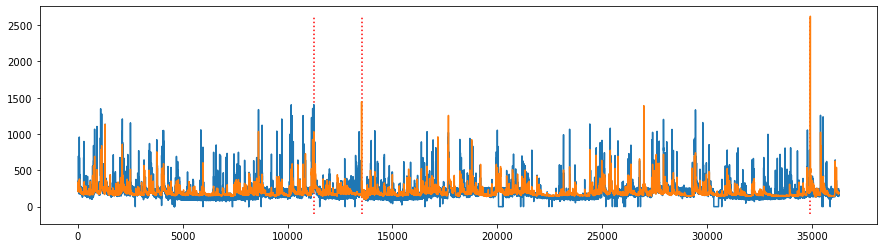

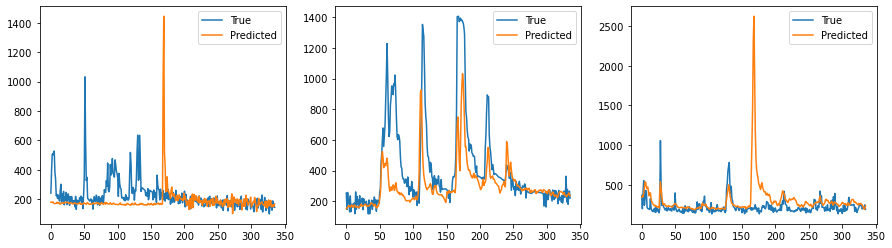

In [25]:
visualize_perforamnce_and_events(y_test_preds_linreg)

In [26]:
def extract_best_performances(dict_obj):
    return pd.DataFrame(dict_obj).min(axis=1).loc[['mse_train','mse_test','mae_train','mae_test']].rename(lambda x : 'best_' + x).to_dict()

In [28]:
lag_values = np.arange(2,168*2,10)
history_list_linreg_lag = []
for lag in lag_values:
    
    history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(), params = -1, lag = lag)

    history_list_linreg_lag.append(history_dict_linreg)
    
    
df_history_linreg_lag = pd.DataFrame([pd.DataFrame(i).T.mean(axis=0) for i in history_list_linreg_lag])
df_history_linreg_lag.index = lag_values


In [29]:
wandb.init(project='model_comparison_with_periodic_data',
           config={
               'model':'LinearRegression',
           })

test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_lag)}


for test in test_dict:
    test_dict[test]['lag'] = test
    wandb.log(test_dict[test])
    
best_results_linreg = extract_best_performances(test_dict)
wandb.log(best_results_linreg)

In [30]:
best_results_linreg

{'best_mse_train': 7411.321177855783,
 'best_mse_test': 7799.204345175502,
 'best_mae_train': 51.607635783345884,
 'best_mae_test': 51.607635783345884}

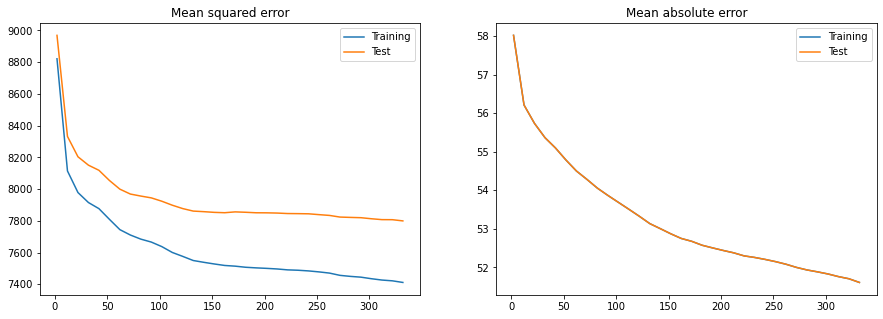

best lag for 2 variables: 332


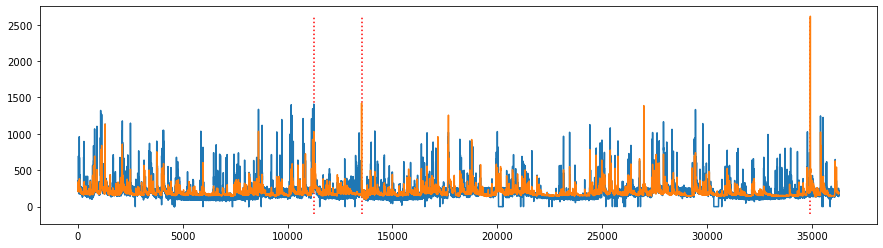

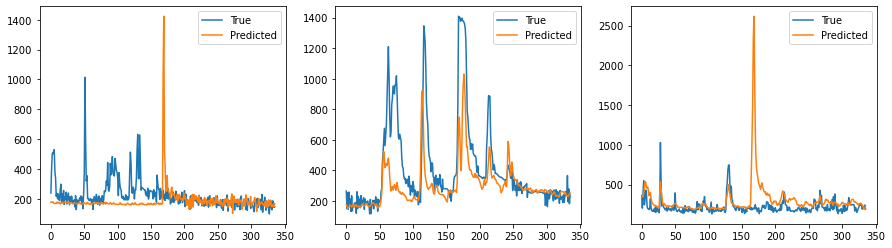

In [31]:
visualize_history_dict(df_history_linreg_lag)
best_lag = df_history_linreg_lag.mse_test.idxmin()
print('best lag for 2 variables:',best_lag)
history_dict_linreg_lag, models_linreg_lag, y_test_preds_linreg_lag = evaluate_model(LinearRegression(), params = -1, lag = best_lag)
visualize_perforamnce_and_events(y_test_preds_linreg_lag)

In [32]:
# kernel = DotProduct() + WhiteKernel() + RationalQuadratic()

# validation_ratio = 0.5
# lag = 168*2
# # n_vars = 1
# # X = input_sequences[:,-lag:,-1].reshape((-1,lag*n_vars))
# # n_vars = 4
# # X = input_sequences[:,-lag:].reshape((-1,lag*n_vars))
# n_vars = 2
# X = input_sequences[:,-lag:,[0,-1]]#.reshape((-1,lag*n_vars))
# X = np.transpose(X,(0,2,1)).reshape(-1,2*lag)

# # time_of_day = np.arange(0,len(output_sequences))%24
# # X = np.c_[X,time_of_day]

# y = output_sequences


# n_train = int(len(X)*(1-validation_ratio))
# X_train = X[:n_train]
# y_train = y[:n_train]
# X_test = X[n_train:]
# y_test = y[n_train:]


# n_subset = 1000 # 58/52 og GEL with 1000 and time of day
# indexes = np.random.choice(len(X_train),n_subset)

# # gpr = GaussianProcessRegressor(kernel=kernel,
# #                                random_state=0,
# #                               #  alpha= 20,
# #                                ).fit(X_train[indexes],y_train[indexes])

# # gpr = SVR('rbf', gamma  = 0.001).fit(X_train[indexes],y_train[indexes])

# gpr = Ridge(0).fit(X_train,y_train)
# # gpr = ARDRegression().fit(X_train[indexes],y_train[indexes])

# # Y_pred = gpr.predict(X, return_std=False)
# Y_pred = gpr.predict(X)
# print(np.mean(np.abs(Y_pred[:n_train] - y[:n_train])))
# print(np.mean(np.abs(Y_pred[n_train:] - y[n_train:])))

# Linear regression with temperature

In [33]:
history_list_linreg_lag_variables = []
for lag in lag_values:
    history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(), params = [0,-1], lag = lag)
    history_list_linreg_lag_variables.append(history_dict_linreg)
df_history_linreg_lag_variables = pd.DataFrame([pd.DataFrame(i).T.mean(axis=0) for i in history_list_linreg_lag_variables])
df_history_linreg_lag_variables.index = lag_values


In [34]:
wandb.init(project='model_comparison',
           config={
               'model':'LinearRegression with temperature',
           })
test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_lag_variables)}

for test in test_dict:
    test_dict[test]['lag'] = test
    wandb.log(test_dict[test])
    
best_results_linreg_temp = extract_best_performances(test_dict)
wandb.log(best_results_linreg_temp)

In [37]:
best_results_linreg_temp

{'best_mse_train': 6324.3845008892495,
 'best_mse_test': 6831.927065039842,
 'best_mae_train': 43.242891661188516,
 'best_mae_test': 43.242891661188516}

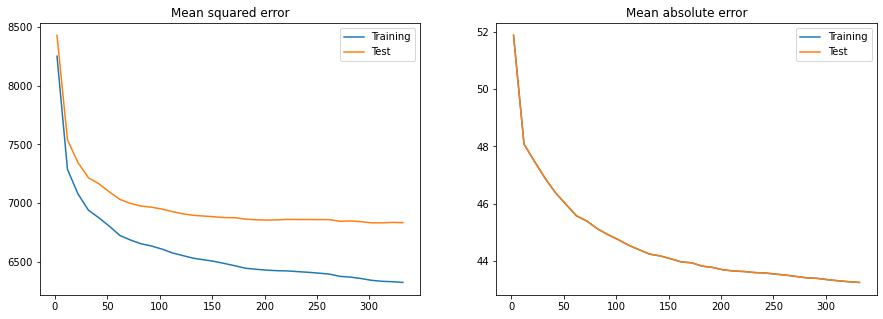

best lag for 2 variables: 312


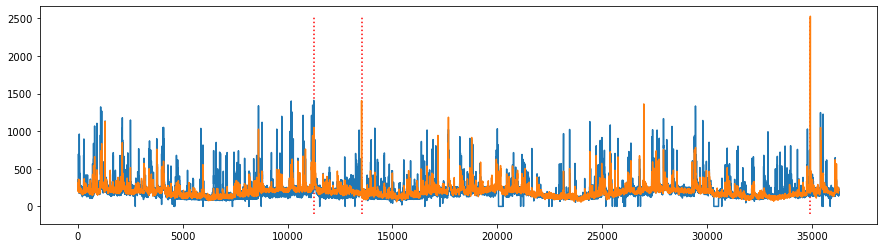

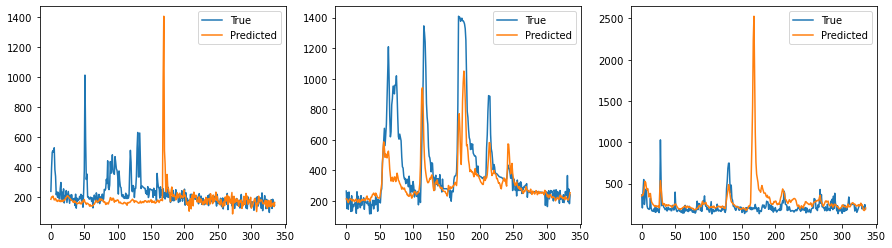

In [39]:
visualize_history_dict(df_history_linreg_lag_variables)
best_lag_variables = df_history_linreg_lag_variables.mse_test.idxmin()
print('best lag for 2 variables:',best_lag_variables)
_, _, y_test_preds_linreg_lag_variables = evaluate_model(LinearRegression(), params = [0,3], lag = best_lag_variables)
visualize_perforamnce_and_events(y_test_preds_linreg_lag_variables)

# Linear regression with more environmental variables

In [40]:
lag_values = np.arange(2,168*2,10)
history_list_linreg_all_vars = []
for lag in lag_values:
    history_dict_linreg, models_linreg, y_test_preds_linreg = evaluate_model(LinearRegression(),params = [0,1,2,3],lag = lag)
    history_list_linreg_all_vars.append(history_dict_linreg)
    
df_history_list_linreg_all_vars = pd.DataFrame([pd.DataFrame(i).T.mean(axis=0) for i in history_list_linreg_all_vars])
df_history_list_linreg_all_vars.index = lag_values


In [41]:
wandb.init(project='model_comparison',
           config={
               'model':'LinearRegression with all variables',
           })
test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_all_vars)}

for test in test_dict:
    test_dict[test]['lag'] = test
    wandb.log(test_dict[test])
    
best_results_linreg_all = extract_best_performances(test_dict)
wandb.log(best_results_linreg_all)

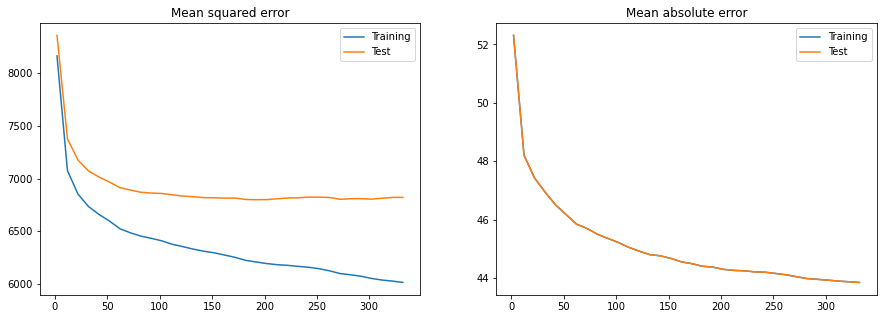

best lag for 2 variables: 312


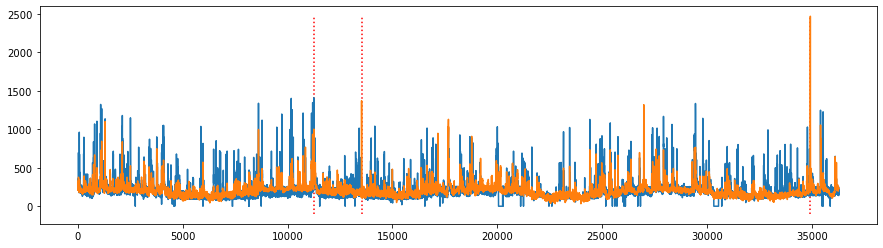

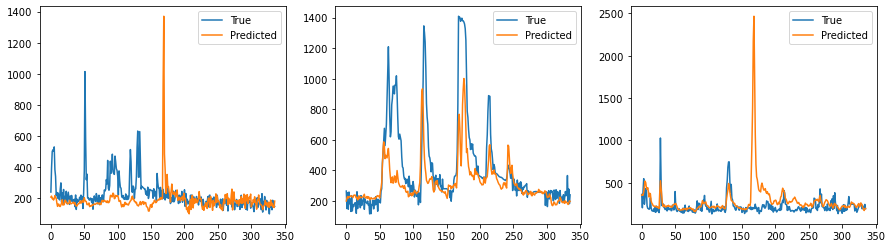

In [42]:
visualize_history_dict(df_history_list_linreg_all_vars)
best_lag_all_vars = df_history_list_linreg_all_vars.mse_test.idxmin()
print('best lag for 2 variables:',best_lag_variables)
_, _, y_test_preds_linreg_lag_all_vars = evaluate_model(LinearRegression(), params = [0,1,2,3], lag = best_lag_all_vars)
visualize_perforamnce_and_events(y_test_preds_linreg_lag_all_vars)

# Using LSTMs for temporal relationships

LSTM training:
- We must train the model 10 different times, each time with different initial parameteres, to get a good estimate of the average performance
 

In [47]:
project = 'LSTM_training'
config = {
    'Dense_1': 2,
    'activation_1': 'relu',
    'LSTM' : 100,
    'Dense_2': 2,
    'activation_2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 50,
    'batch_size': 32,
    'lr' : 0.01,
    'lr_decay' : 0.9,
    'lag' : 168,
    'early_stopper_patience' : 3,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(-2,-4,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)

def construct_simple_encoder_decoder_lstm():

    model = Sequential()
    model.add(Input((wandb.config['lag'],1)))
    model.add(Dense(wandb.config['Dense_1'],
                    activation=wandb.config['activation_1']
                    ))
    model.add(LSTM(wandb.config['LSTM'],
                   return_sequences=True))
    model.add(Dense(wandb.config['Dense_2'],
                    activation=wandb.config['activation_2']))
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model

# tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

refresh_wandb()
with tf.device('/cpu:0'):
    history_dict_lstm, models_lstm, y_test_preds_lstm = evaluate_model(None,
                                                                        params = [-1],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_simple_encoder_decoder_lstm,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
907/907 [==============================] - 50s 53ms/step - loss: 12671.8145 - mean_absolute_error: 65.1048 - mean_squared_error: 12671.8145 - correlation: 0.0647 - val_loss: 14669.7363 - val_mean_absolute_error: 74.2557 - val_mean_squared_error: 14669.7363 - val_correlation: nan
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
907/907 [==============================] - 47s 52ms/step - loss: 10620.9844 - mean_absolute_error: 59.9963 - mean_squared_error: 10620.9844 - correlation: 0.4255 - val_loss: 8570.5371 - val_mean_absolute_error: 59.2658 - val_mean_squared_error: 8570.5371 - val_correlation: nan
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
907/907 [==============================] - 46s 50ms/step - loss: 8066.8257 - mean_absolute_error: 55.5058 - mean_squared_error: 8066.8257 - correlation: 0.5539 - val_loss: 8165.2817 - val_mean_absolute_error:

KeyboardInterrupt: 

In [ ]:
wandb.init(project='model_comparison',
           config={
               'model':'LSTM with a single variable',
           })
test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_all_vars)}

for test in history_dict_lstm:
    history_dict_lstm[test]['fold'] = test
    
    print(history_dict_lstm[test])
    # wandb.log(history_dict_lstm[test])
    
best_results_lstm = extract_best_performances(history_dict_lstm)
wandb.log(best_results_lstm)
best_results_lstm

{'mse_train': 6687.0415, 'mse_test': 7186.2026, 'mae_train': 52.511868, 'mae_test': 52.511868, 'fold': 0}
{'mse_train': 6195.983, 'mse_test': 8996.416, 'mae_train': 51.385056, 'mae_test': 51.385056, 'fold': 1}
{'mse_train': 37010.973, 'mse_test': 35478.89, 'mae_train': 155.75644, 'mae_test': 155.75644, 'fold': 2}
{'mse_train': 7342.318, 'mse_test': 5806.451, 'mae_train': 53.22102, 'mae_test': 53.22102, 'fold': 3}
{'mse_train': 6664.303, 'mse_test': 6701.386, 'mae_train': 52.191032, 'mae_test': 52.191032, 'fold': 4}


{'best_mse_train': 6195.98291015625,
 'best_mse_test': 5806.451171875,
 'best_mae_train': 51.38505554199219,
 'best_mae_test': 51.38505554199219}

# Using LSTMs with in addition to more weather data for potential hydrological modelling

In [ ]:
project = 'LSTM_training'
config = {
    'Dense_1': 2,
    'activation_1': 'relu',
    'LSTM' : 10,
    'Dense_2': 2,
    'activation_2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 50,
    'batch_size': 32,
    'lr' : 0.001,
    'lr_decay' : 0.9,
    'lag' : 168,
    'early_stopper_patience' : 3,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(0,-5,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_simple_encoder_decoder_lstm_with_temperature():
    
    model = Sequential()
    model.add(Input((wandb.config['lag'],2)))
    model.add(Dense(wandb.config['Dense_1'],
                    activation=wandb.config['activation_1']
                    ))
    model.add(LSTM(wandb.config['LSTM'],
                   return_sequences=True))
    model.add(Dense(wandb.config['Dense_2'],
                    activation=wandb.config['activation_2']))
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model

refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_temp, models_lstm_temp, y_test_preds_lstm_temp = evaluate_model(None,
                                                                        params = [0,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_simple_encoder_decoder_lstm_with_temperature,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            # lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/50
907/907 [==============================] - 16s 15ms/step - loss: 15068.4082 - mean_absolute_error: 71.1487 - mean_squared_error: 15068.4082 - correlation: 0.3363 - val_loss: 11078.3965 - val_mean_absolute_error: 57.1059 - val_mean_squared_error: 11078.3965 - val_correlation: nan
Epoch 2/50
907/907 [==============================] - 12s 13ms/step - loss: 10269.0625 - mean_absolute_error: 51.5800 - mean_squared_error: 10269.0625 - correlation: 0.4717 - val_loss: 10714.7949 - val_mean_absolute_error: 52.3962 - val_mean_squared_error: 10714.7949 - val_correlation: nan
Epoch 3/50
907/907 [==============================] - 13s 15ms/step - loss: 9813.5361 - mean_absolute_error: 50.3031 - mean_squared_error: 9813.5361 - correlation: 0.5067 - val_loss: 9686.9238 - val_mean_absolute_error: 51.4776 - val_mean_squared_error: 9686.9238 - val_correlation: 0.1271
Epoch 4/50
907/907 [==============================] - 13s 14ms/step - loss: 9238.4531 - mean_absolute_error: 49.0362 - mean_squa

In [ ]:
wandb.init(project='model_comparison',
           config={
               'model':'LSTM with temperature',
           })
# test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_all_vars)}

for test in history_dict_lstm_temp:
    history_dict_lstm_temp[test]['fold'] = test
    wandb.log(history_dict_lstm_temp[test])
    
print(history_dict_lstm_temp)
best_results_lstm_temp = extract_best_performances(history_dict_lstm_temp)
wandb.log(best_results_lstm_temp)
best_results_lstm_temp

{0: {'mse_train': 5168.698, 'mse_test': 6131.178, 'mae_train': 41.769363, 'mae_test': 41.769363, 'fold': 0}, 1: {'mse_train': 5072.6543, 'mse_test': 7710.092, 'mae_train': 41.599545, 'mae_test': 41.599545, 'fold': 1}, 2: {'mse_train': 10907.42, 'mse_test': 9676.259, 'mae_train': 53.470585, 'mae_test': 53.470585, 'fold': 2}, 3: {'mse_train': 6007.4917, 'mse_test': 4647.2744, 'mae_train': 46.26594, 'mae_test': 46.26594, 'fold': 3}, 4: {'mse_train': 5815.9473, 'mse_test': 6268.8247, 'mae_train': 44.277084, 'mae_test': 44.277084, 'fold': 4}}


{'best_mse_train': 5072.654296875,
 'best_mse_test': 4647.2744140625,
 'best_mae_train': 41.599544525146484,
 'best_mae_test': 41.599544525146484}

In [ ]:
project = 'LSTM_training'
config = {
    'Dense_1': 2,
    'activation_1': 'relu',
    'LSTM' : 10,
    'Dense_2': 2,
    'activation_2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 50,
    'batch_size': 32,
    'lr' : 0.001,
    'lr_decay' : 0.9,
    'lag' : 168,
    'early_stopper_patience' : 3,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(0,-5,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_simple_encoder_decoder_lstm_with_all_variables():
    
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_1'],
                    activation=wandb.config['activation_1']
                    ))
    model.add(LSTM(wandb.config['LSTM'],
                   return_sequences=True))
    model.add(Dense(wandb.config['Dense_2'],
                    activation=wandb.config['activation_2']))
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model

refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_all, models_lstm_all, y_test_preds_lstm_all = evaluate_model(None,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_simple_encoder_decoder_lstm_with_all_variables,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            # lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/50
907/907 [==============================] - 18s 18ms/step - loss: 14391.0889 - mean_absolute_error: 69.8021 - mean_squared_error: 14391.0889 - correlation: 0.2740 - val_loss: 11537.3887 - val_mean_absolute_error: 58.6009 - val_mean_squared_error: 11537.3887 - val_correlation: 0.0916
Epoch 2/50
907/907 [==============================] - 16s 17ms/step - loss: 10719.1543 - mean_absolute_error: 54.8652 - mean_squared_error: 10719.1543 - correlation: 0.4200 - val_loss: 11009.0908 - val_mean_absolute_error: 57.9992 - val_mean_squared_error: 11009.0908 - val_correlation: 0.1152
Epoch 3/50
907/907 [==============================] - 15s 17ms/step - loss: 10456.8955 - mean_absolute_error: 53.8206 - mean_squared_error: 10456.8955 - correlation: 0.4465 - val_loss: 10801.0801 - val_mean_absolute_error: 57.1267 - val_mean_squared_error: 10801.0801 - val_correlation: 0.1125
Epoch 4/50
907/907 [==============================] - 14s 15ms/step - loss: 10149.4033 - mean_absolute_error: 52.6456 

In [ ]:
history_dict_lstm_all

{0: {'mse_train': 5472.3237,
  'mse_test': 6514.931,
  'mae_train': 41.153057,
  'mae_test': 41.153057,
  'fold': 0},
 1: {'mse_train': 9804.343,
  'mse_test': 15195.922,
  'mae_train': 55.651962,
  'mae_test': 55.651962,
  'fold': 1},
 2: {'mse_train': 6105.565,
  'mse_test': 6773.964,
  'mae_train': 43.450546,
  'mae_test': 43.450546,
  'fold': 2},
 3: {'mse_train': 5961.153,
  'mse_test': 4720.514,
  'mae_train': 45.39275,
  'mae_test': 45.39275,
  'fold': 3},
 4: {'mse_train': 10931.696,
  'mse_test': 10365.353,
  'mae_train': 56.317318,
  'mae_test': 56.317318,
  'fold': 4}}

In [ ]:
wandb.init(project='model_comparison',
           config={
               'model':'LSTM with all variables',
               'lag':0
           })
# test_dict = {i:pd.DataFrame(value).T.mean(axis=0).to_dict() for i,value in zip(lag_values,history_list_linreg_all_vars)}

for test in history_dict_lstm_all:
    history_dict_lstm_all[test]['lag'] = test
    print(history_dict_lstm_all[test])
    wandb.log(history_dict_lstm_all[test])
    
# print(history_dict_lstm_all)
best_results_lstm_all = extract_best_performances(history_dict_lstm_all)
wandb.log(best_results_lstm_all)
best_results_lstm_all

{'mse_train': 5472.3237, 'mse_test': 6514.931, 'mae_train': 41.153057, 'mae_test': 41.153057, 'fold': 0, 'lag': 0}
{'mse_train': 9804.343, 'mse_test': 15195.922, 'mae_train': 55.651962, 'mae_test': 55.651962, 'fold': 1, 'lag': 1}
{'mse_train': 6105.565, 'mse_test': 6773.964, 'mae_train': 43.450546, 'mae_test': 43.450546, 'fold': 2, 'lag': 2}
{'mse_train': 5961.153, 'mse_test': 4720.514, 'mae_train': 45.39275, 'mae_test': 45.39275, 'fold': 3, 'lag': 3}
{'mse_train': 10931.696, 'mse_test': 10365.353, 'mae_train': 56.317318, 'mae_test': 56.317318, 'fold': 4, 'lag': 4}


{'best_mse_train': 5472.32373046875,
 'best_mse_test': 4720.51416015625,
 'best_mae_train': 41.15305709838867,
 'best_mae_test': 41.15305709838867}

# LSTM with all variables and more complex encoder-decoder structure

In [ ]:
project = 'LSTM_training'
config = {
    'Dense_E1': 2,
    'Dense_E2': 2,
    'activation_E1': 'relu',
    'activation_E2': 'relu',
    'LSTM' : 10,
    'Dense_D1': 2,
    'Dense_D2': 1,
    'activation_D1': 'relu',
    'activation_D2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 50,
    'batch_size': 16,
    'lr' : 0.01,
    'lag' : 168,
    'early_stopper_patience' : 6,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(-2,-4,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_simple_encoder_decoder_lstm_with_all_variables():
    
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_E1'],activation=wandb.config['activation_E1']))
    model.add(Dense(wandb.config['Dense_E2'],activation=wandb.config['activation_E2']))
    model.add(LSTM(wandb.config['LSTM'],return_sequences=True))
    model.add(Dense(wandb.config['Dense_D1'],activation=wandb.config['activation_D1']))
    model.add(Dense(wandb.config['Dense_D2'],activation=wandb.config['activation_D2']))
    model.add(Flatten())
    model.add(Dense(1,activation='linear'))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model


In [ ]:
refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_all, models_lstm_all, y_test_preds_lstm_all = evaluate_model(None,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_simple_encoder_decoder_lstm_with_all_variables,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
1814/1814 [==============================] - 33s 15ms/step - loss: 11399.3125 - mean_absolute_error: 58.1042 - mean_squared_error: 11399.3125 - correlation: 0.4105 - val_loss: 11195.3125 - val_mean_absolute_error: 57.2678 - val_mean_squared_error: 11195.3125 - val_correlation: 0.0692
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
1814/1814 [==============================] - 26s 14ms/step - loss: 10822.9590 - mean_absolute_error: 54.9230 - mean_squared_error: 10822.9590 - correlation: 0.4702 - val_loss: 10171.2197 - val_mean_absolute_error: 53.6022 - val_mean_squared_error: 10171.2197 - val_correlation: 0.1001
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
1814/1814 [==============================] - 26s 14ms/step - loss: 9405.9570 - mean_absolute_error: 52.3100 - mean_squared_error: 9405.9570 - correlation: 0.5568 - val_loss: 8872.8574 - val_mean_a

KeyboardInterrupt: 

# 

# 

# 

# 

# 

# 

# 

# Seq-to-seq architecture

In [ ]:
project = 'LSTM_training'
config = {
    'name' : 'random_variations',
    'Dense_E1': 2,
    'Dense_E2': 2,
    'activation_E1': 'relu',
    'activation_E2': 'relu',
    'LSTM' : 10,
    'Dense_D1': 2,
    'Dense_D2': 1,
    'activation_D1': 'relu',
    'activation_D2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 10,
    'batch_size': 16,
    'lr' : 0.01,
    'lag' : 168,
    'early_stopper_patience' : 6,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(-1,-4,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_test_model():
    
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_E1'],activation=wandb.config['activation_E1']))
    model.add(Dense(wandb.config['Dense_E2'],activation=wandb.config['activation_E2']))
    model.add(LSTM(wandb.config['LSTM'],return_sequences=True))
    model.add(Dense(wandb.config['Dense_D1'],activation=wandb.config['activation_D1']))
    # model.add(Dense(wandb.config['Dense_D2'],activation=wandb.config['activation_D2']))
    model.add(Flatten())
    model.add(Dense(1,activation='linear'))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model



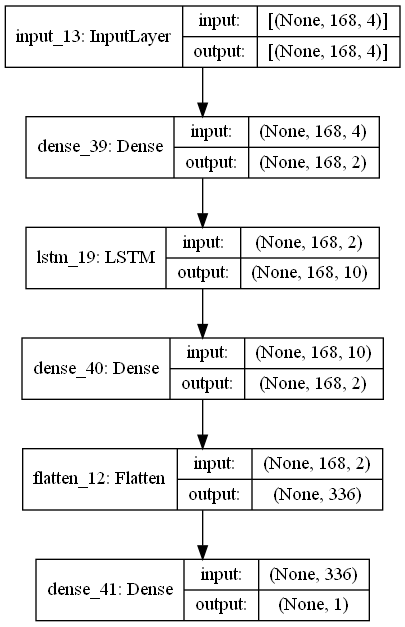

In [ ]:
model = construct_test_model()
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)


In [ ]:
refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_all, models_lstm_all, y_test_preds_lstm_all = evaluate_model(None,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_test_model,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
1814/1814 [==============================] - 30s 15ms/step - loss: 11786.9941 - mean_absolute_error: 61.2352 - mean_squared_error: 11786.9941 - correlation: 0.3965 - val_loss: 12234.5547 - val_mean_absolute_error: 60.5387 - val_mean_squared_error: 12234.5547 - val_correlation: nan
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.05011872336272722.
1814/1814 [==============================] - 25s 14ms/step - loss: 11036.2803 - mean_absolute_error: 57.4575 - mean_squared_error: 11036.2803 - correlation: 0.4422 - val_loss: 11355.4639 - val_mean_absolute_error: 66.4569 - val_mean_squared_error: 11355.4639 - val_correlation: 0.1249
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.025118864315095794.
1814/1814 [==============================] - 24s 13ms/step - loss: 9862.0225 - mean_absolute_error: 55.2736 - mean_squared_error: 9862.0225 - correlation: 0.4805 - val_l

KeyboardInterrupt: 

# Seq-to-seq with attention

In [ ]:
project = 'LSTM_training'
config = {
    'name' : 'random_variations',
    'Dense_E1': 2,
    'Dense_E2': 2,
    'activation_E1': 'relu',
    'activation_E2': 'relu',
    'LSTM' : 10,
    'Dense_D1': 2,
    'Dense_D2': 1,
    'activation_D1': 'relu',
    'activation_D2': 'relu',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 10,
    'batch_size': 16,
    'lr' : 0.01,
    'lag' : 168,
    'early_stopper_patience' : 6,
    'fold':0,
}
wandb.init(project=project,config=config)

def refresh_wandb(fold = False):
    if fold:
        config['fold'] += 1
    else:
        config['fold'] = 0
    wandb.init(project = project,
               config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(-1,-4,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)


def construct_attention_model():
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_E1'],activation=wandb.config['activation_E1']))
    model.add(Dense(wandb.config['Dense_E2'],activation=wandb.config['activation_E2']))
    model.add(LSTM(wandb.config['LSTM'],return_sequences=True))
    
    
    
    inputs = Input(shape=(wandb.config['lag'], 4))
    lstm_out = LSTM(wandb.config['LSTM'], return_sequences=True)(inputs)

    attention = Dense(1, activation='elu')(lstm_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(hidden)(attention)
    attention = Permute([2,1])(attention)

    combined = Multiply()([lstm_out, attention])
    combined_mul = Flatten()(combined)
    decode = RepeatVector(output_length)(combined_mul)
    decode = LSTM(hidden, return_sequences=True)(decode)
    decode = TimeDistributed(Dense(1))(decode)
    decode = Activation('linear')(decode)

    model = Model(inputs=[inputs], outputs=decode)

    # model = Sequential()
    # model.add(Input((wandb.config['lag'],4)))
    # model.add(Dense(wandb.config['Dense_E1'],activation=wandb.config['activation_E1']))
    # model.add(Dense(wandb.config['Dense_E2'],activation=wandb.config['activation_E2']))
    # model.add(LSTM(wandb.config['LSTM'],return_sequences=True))
    # model.add(Dense(wandb.config['Dense_D1'],activation=wandb.config['activation_D1']))
    # # model.add(Dense(wandb.config['Dense_D2'],activation=wandb.config['activation_D2']))
    # model.add(Flatten())
    # model.add(Dense(1,activation='linear'))
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=wandb.config['lr']),
                  loss = tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE,
                           tfp.stats.correlation])
    refresh_wandb(True)
    return model



In [ ]:
from tensorflow.keras import Model

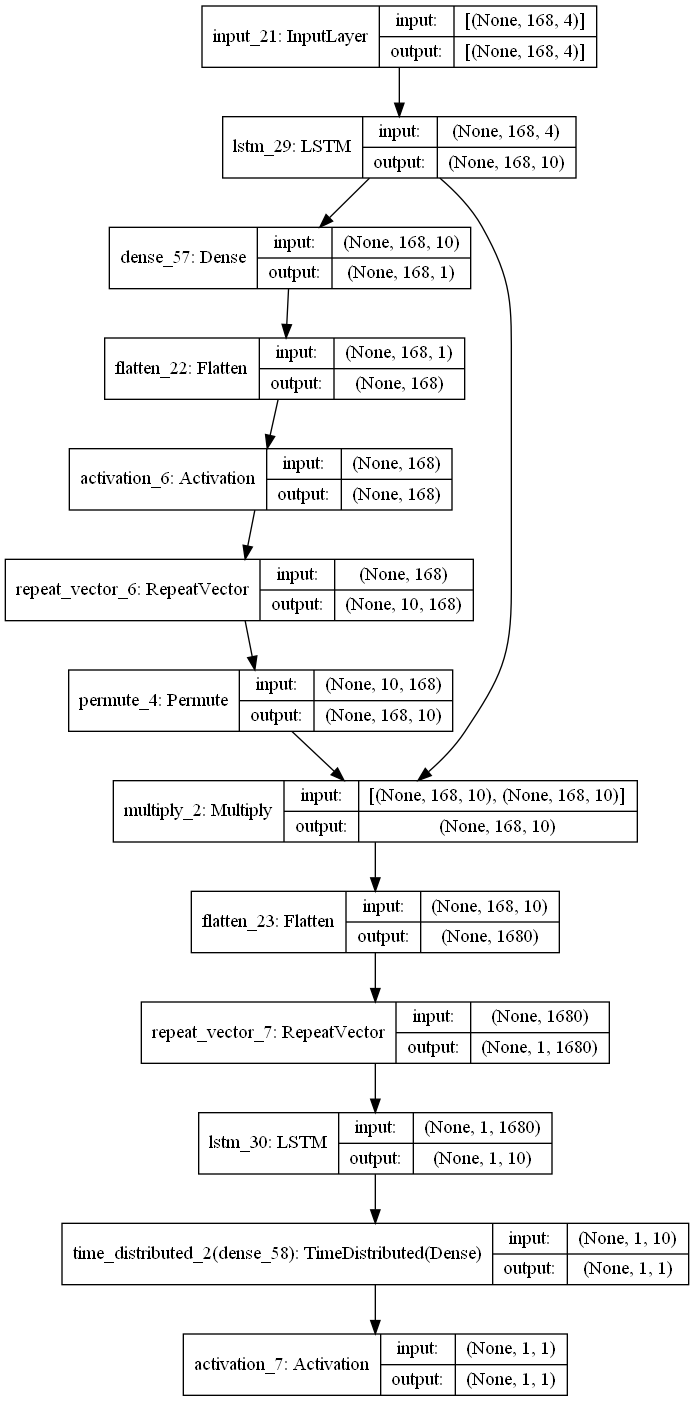

In [ ]:
model = construct_attention_model()
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [ ]:
refresh_wandb()
with tf.device('/gpu:0'):
    history_dict_lstm_all, models_lstm_all, y_test_preds_lstm_all = evaluate_model(None,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = construct_attention_model,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
1814/1814 [==============================] - 33s 17ms/step - loss: 14162.3916 - mean_absolute_error: 69.8887 - mean_squared_error: 14162.3916 - correlation: nan - val_loss: 13834.1211 - val_mean_absolute_error: 73.7180 - val_mean_squared_error: 13834.1211 - val_correlation: nan
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.05011872336272722.
   9/1814 [..............................] - ETA: 26s - loss: 10015.6719 - mean_absolute_error: 65.7462 - mean_squared_error: 10015.6719 - correlation: 0.3409

C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


1814/1814 [==============================] - 27s 15ms/step - loss: 12233.1416 - mean_absolute_error: 63.2429 - mean_squared_error: 12233.1416 - correlation: 0.2733 - val_loss: 13875.7715 - val_mean_absolute_error: 73.5569 - val_mean_squared_error: 13875.7715 - val_correlation: nan
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.025118864315095794.
1814/1814 [==============================] - 28s 15ms/step - loss: 12230.2090 - mean_absolute_error: 63.1895 - mean_squared_error: 12230.2090 - correlation: 0.2688 - val_loss: 13853.1367 - val_mean_absolute_error: 73.6337 - val_mean_squared_error: 13853.1367 - val_correlation: nan
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.012589254117941675.
1814/1814 [==============================] - 29s 16ms/step - loss: 12227.1016 - mean_absolute_error: 63.1737 - mean_squared_error: 12227.1016 - correlation: 0.2768 - val_loss: 13851.9863 - val_mean_absolute_error: 73.6382 - val_mean_squared_error: 

KeyboardInterrupt: 

In [ ]:

optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])

with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 5,
            shuffle=True,
            )

Epoch 1/5
1755/1755 [==============================] - 27s 14ms/step - loss: 5190.4229 - mean_absolute_error: 44.4317 - mean_squared_error: 5190.4229 - correlation: 0.6902 - val_loss: 5429.1313 - val_mean_absolute_error: 42.5812 - val_mean_squared_error: 5429.1313 - val_correlation: nan
Epoch 2/5
1755/1755 [==============================] - 23s 13ms/step - loss: 4107.9946 - mean_absolute_error: 39.1785 - mean_squared_error: 4107.9946 - correlation: 0.7568 - val_loss: 3975.3423 - val_mean_absolute_error: 38.0471 - val_mean_squared_error: 3975.3423 - val_correlation: nan
Epoch 3/5
1755/1755 [==============================] - 22s 13ms/step - loss: 3913.5334 - mean_absolute_error: 38.6908 - mean_squared_error: 3913.5334 - correlation: 0.7673 - val_loss: 3742.0952 - val_mean_absolute_error: 37.8542 - val_mean_squared_error: 3742.0952 - val_correlation: nan
Epoch 4/5
1755/1755 [==============================] - 24s 14ms/step - loss: 3864.4607 - mean_absolute_error: 38.5361 - mean_squared_err

In [ ]:
n_train08 = int(len(output_sequences) * 0.8)
y_pred = model.predict(input_sequences[n_train08:,-lag:,])

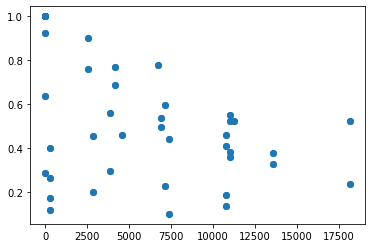

In [ ]:
for key in gauge_pairs_corr:
    print(key)
    print(len(df_sensors.loc[df_sensors.loc['STOD']]))

{'1473': {'1473': [0.0820667864274306,
   0.08494206530306446,
   0.08259674934912269,
   0.08332347250676511,
   0.08559919101513706,
   0.08851701476992728,
   0.09451788740170286,
   0.10203331054673885,
   0.10955754150409566,
   0.11461479859983043,
   0.12352555222707161,
   0.1353085177238702,
   0.15442493067186397,
   0.18067944637636846,
   0.21085477546368642,
   0.251761086963745,
   0.31327783657670344,
   0.4048715351590043,
   0.5226571510653925,
   0.7150020778845789,
   1.0,
   0.71500207788458,
   0.5226571510653927,
   0.4048715351590047,
   0.3132778365767036,
   0.2517610869637453,
   0.21085477546368644,
   0.1806794463763685,
   0.15442493067186414,
   0.13530851772387026,
   0.12352555222707144,
   0.11461479859983051,
   0.1095575415040958,
   0.10203331054673885,
   0.09451788740170264,
   0.08851701476992721,
   0.08559919101513701,
   0.08332347250676525,
   0.08259674934912246,
   0.08494206530306452],
  '1475': [0.030898294935410787,
   0.03346698681678247

# Rain-gauge drainage flow correlation

In [ ]:
lag_values = range(-20,20)
corr_dict = {}
for drainage_name in df_target.columns:
    print(drainage_name)
    tmp_dict = {}
    for gauge_name in processed_gauges.columns:
        X_tmp = processed_gauges.loc[:,gauge_name]
        Y_tmp = df_target.loc[:,drainage_name]
        tmp_dict[gauge_name] = pair_lag_correlations(X_tmp,Y_tmp,lag_values)
    corr_dict[drainage_name] = tmp_dict

# this is just for a dict that can be turned into a dataframe
df_corr_all = pd.DataFrame(corr_dict)

RVK-SEI
RVK-BOD
RVK-VES
KOP-HAB
RVK-SKE
RVK-FAX
RVK-ANA
MOS-HOL


C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


RVK-ING
RVK-LAU
RVK-GUF
RVK-GEL
RVK-KLE


# Selecting the subeset of data for which other weather observations are available

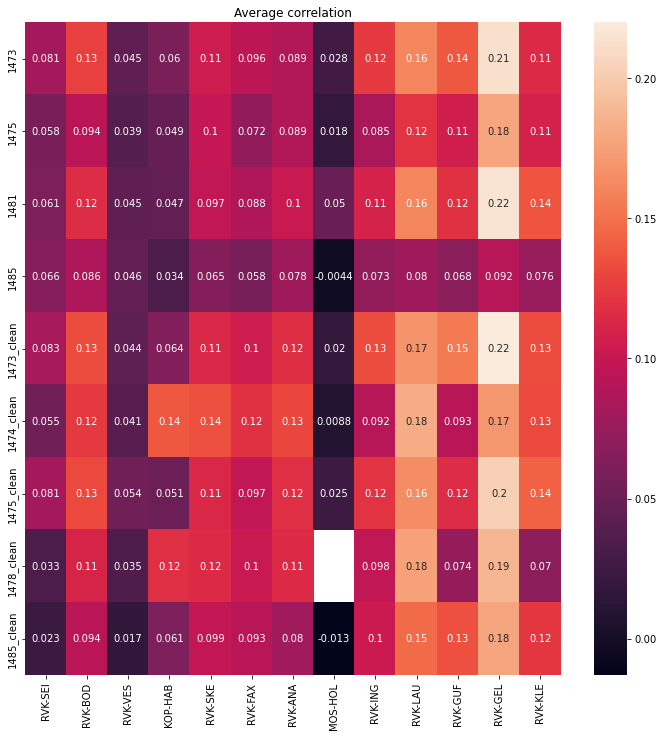

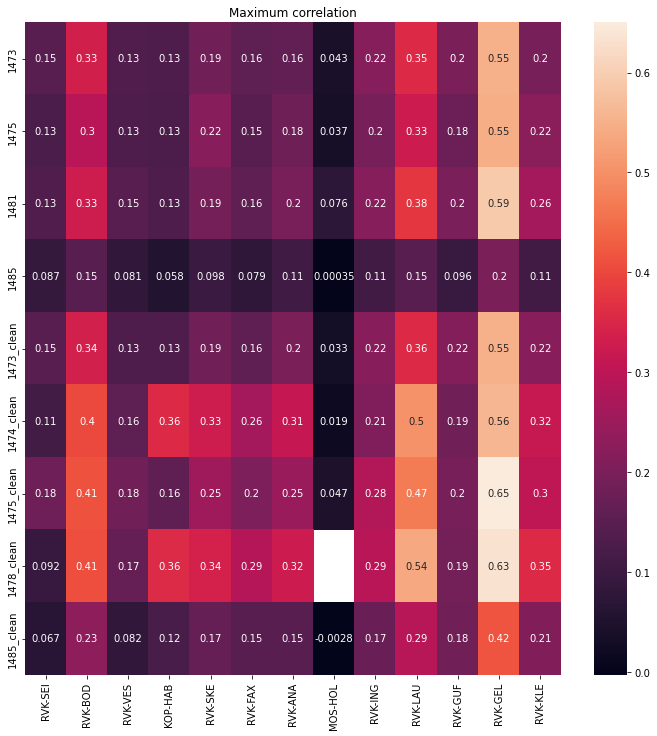

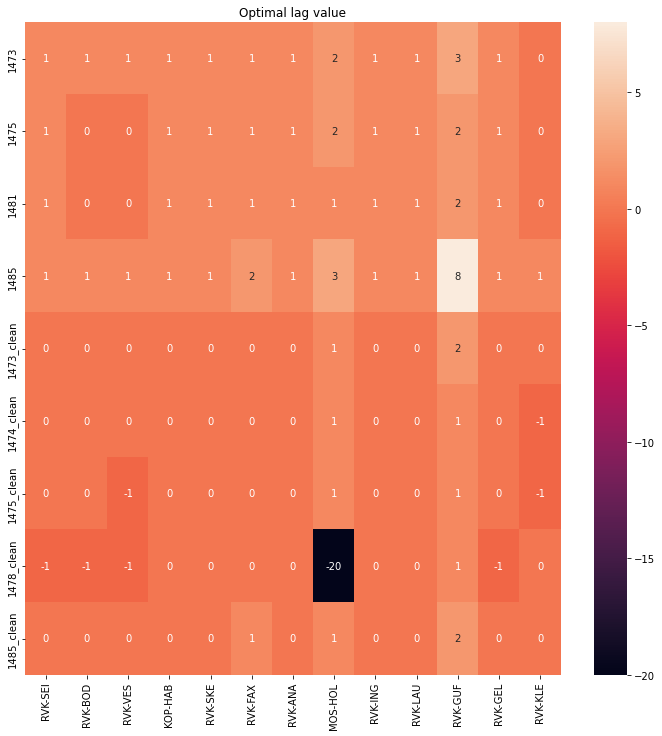

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(df_corr_all.applymap(np.mean),annot=True)
plt.title('Average correlation')
plt.show()

plt.figure(figsize=(12,12))
sns.heatmap(df_corr_all.applymap(np.max),annot=True)
plt.title('Maximum correlation')
plt.show()

plt.figure(figsize=(12,12))
sns.heatmap(df_corr_all.applymap(lambda x : int(lag_values[np.argmax(x)])),annot=True)
plt.title('Optimal lag value')
plt.show()


# Let's use 1473 to predict for GEL


In [376]:
# cycle_length = 24
# remove_cycle = lambda x,c : (np.nanmax([x[c],0]) + (x.diff(c).cumsum()/c).shift(-c))
# remove_season = lambda x : x - x.rolling(24*7*2,min_periods = 0).min()

Xg = processed_gauges.loc[:,'1475_clean'].resample('1h').sum()
Xw = pd.read_pickle('../../Rainfall - runoff/input_data').loc[:,['temperature','radiation','moist_pressure']]
X = pd.concat([Xw,Xg],axis=1).dropna()
Y = df_target.loc[:,'RVK-BOD'].resample('1h').sum()

lag = 1500
input_sequences,output_sequences,date_sequences =\
    get_x_y_with_lag(lag,
                     input_data = X,
                     output_data = Y,
                     dt_start = X.index.min(),
                     dt_end = datetime.datetime(2020,12,31,23,59,59))

# Comparing rainfall-runoff models

# Linear regression model on lagged values


In [379]:
# plt.plot(output_sequences)

In [383]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error

train_performance_dict = {}
test_performance_dict = {}
lag_values = np.arange(2,24*7*3,10)
alphas = np.logspace(-4,4,9)

for lag in lag_values:
    for alpha in alphas:
        # print('Using lag: ',lag)
        input_sequences_subset,output_sequences_subset = input_sequences[:,-lag:,-1],output_sequences
        n_train = int(len(input_sequences_subset)*0.5)
        # linreg = LinearRegression().fit(input_sequences_subset[:n_train], output_sequences_subset[:n_train])
        linreg = Ridge(alpha).fit(input_sequences_subset[:n_train], output_sequences_subset[:n_train])

        y_pred_train = linreg.predict(input_sequences_subset[:n_train]) 
        y_pred_test = linreg.predict(input_sequences_subset[n_train:]) 
        corr_func = lambda a,b : np.corrcoef(a,b)[0,1]
        corr_func.__name__ = 'Correlation'
        perf_list_train = {}
        perf_list_test = {}
        for metric in [mean_absolute_error,mean_squared_error,corr_func]:
            train_score = metric(output_sequences_subset[:n_train],y_pred_train)
            test_score = metric(output_sequences_subset[n_train:],y_pred_test)
            perf_list_train[metric.__name__] = train_score
            perf_list_test[metric.__name__] = test_score
            
        train_performance_dict[(lag,alpha)] = perf_list_train
        test_performance_dict[(lag,alpha)] = perf_list_test

In [ ]:
# test_performance_dict

In [381]:
pd.DataFrame(test_performance_dict).T.min(axis=0),pd.DataFrame(train_performance_dict).T.min(axis=0)


(mean_absolute_error     13.862574
 mean_squared_error     325.256854
 Correlation              0.407101
 dtype: float64,
 mean_absolute_error     10.382048
 mean_squared_error     194.664409
 Correlation              0.545784
 dtype: float64)

ValueError: setting an array element with a sequence.

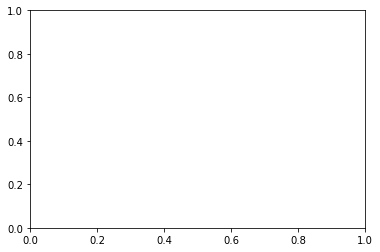

In [382]:
test_scores = pd.DataFrame(test_performance_dict).T
train_scores = pd.DataFrame(train_performance_dict).T
for col in test_scores.columns:
    plt.plot(test_scores.loc[:,col])
    plt.plot(train_scores.loc[:,col])
    plt.title(col)
    plt.legend(['Test','Train'])
    plt.show()

# Gaussian process regression

(<AxesSubplot:>, 62428)

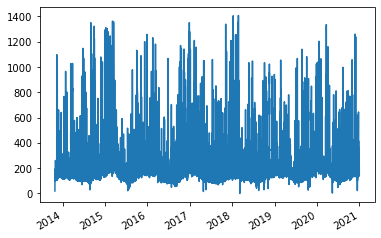

In [365]:
df_target.loc[:,'RVK-GEL'].dropna().plot(),len(df_target.loc[:,'RVK-GEL'].dropna())

In [ ]:
X = pd.concat([Xw,Xg],axis=1).dropna()
Y = df_target.loc[:,'RVK-GEL'].resample('1h').sum()

lag = 1500
input_sequences,output_sequences =\
    get_x_y_with_lag(lag,
                     input_data = X,
                     output_data = Y,
                     dt_start = X.index.min(),
                     dt_end = datetime.datetime(2020,12,31,23,59,59))

In [ ]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.svm import SVR
from sklearn.linear_model import *


In [ ]:

# X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
kernel = DotProduct() + WhiteKernel() + RationalQuadratic()
#+ ExpSineSquared(100,24, periodicity_bounds='fixed')

validation_ratio = 0.5
lag = 168*2
# n_vars = 1
# X = input_sequences[:,-lag:,-1].reshape((-1,lag*n_vars))
# n_vars = 4
# X = input_sequences[:,-lag:].reshape((-1,lag*n_vars))
n_vars = 2
X = input_sequences[:,-lag:,[0,-1]]#.reshape((-1,lag*n_vars))
X = np.transpose(X,(0,2,1)).reshape(-1,2*lag)

# time_of_day = np.arange(0,len(output_sequences))%24
# X = np.c_[X,time_of_day]

y = output_sequences


n_train = int(len(X)*(1-validation_ratio))
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]


n_subset = 2000 # 58/52 og GEL with 1000 and time of day
indexes = np.random.choice(len(X_train),n_subset)

gpr = GaussianProcessRegressor(kernel=kernel,
                               random_state=0,
                              #  alpha= 20,
                               ).fit(X_train[indexes],y_train[indexes])

# gpr = SVR('rbf', gamma  = 0.001).fit(X_train[indexes],y_train[indexes])

# gpr = Ridge(0).fit(X_train,y_train)
# gpr = ARDRegression().fit(X_train[indexes],y_train[indexes])

# Y_pred = gpr.predict(X, return_std=False)
Y_pred = gpr.predict(X)
print(np.mean(np.abs(Y_pred[:n_train] - y[:n_train])))
print(np.mean(np.abs(Y_pred[n_train:] - y[n_train:])))

C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


53.58968291743009
50.82488859573202


In [ ]:
# (y_train - pd.Series(y_train).rolling(24,0).mean()).abs().mean(),(y_test - pd.Series(y_test).rolling(24,0).mean()).abs().mean()
np.mean(np.abs((y_train - np.mean(y_train)))),np.mean(np.abs((y_test - np.mean(y_train))))


(67.7094453678003, 63.67845022607405)

In [ ]:
from sklearn.linear_model import Ridge, ARDRegression, LinearRegression

In [ ]:
# plt.plot(Y_pred[0])

In [ ]:
# X.shape,X_train.shape,n_train,y_train.shape,Y_pred.shape

In [ ]:
# plt.plot(input_sequences[0,-168:,0])
# plt.plot(input_sequences[0,-168:,-1])

In [ ]:
# plt.plot(X[0][::2])
# plt.plot(X[0][1::2])
# X[0].shape

In [ ]:
# # plt.scatter(X[:,-1],y)
# plt.scatter(X[:,-99],y)
# x_indexes = np.linspace(0,15,20)
# temp_indexes = np.linspace(0,15,20)

In [ ]:
gpr.score(X_test, y_test)

0.515766666166673

ValueError: x and y must be the same size

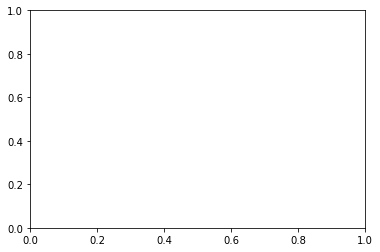

In [ ]:
plt.scatter(Y_pred,y_test)

In [ ]:
show = 10000
plt.plot(output_sequences[n_subset:n_subset + show])
plt.plot(Y_pred[n_subset:n_subset + show])
plt.show()

plt.plot(output_sequences[:n_subset])
plt.plot(Y_pred[:n_subset])
plt.show()

In [ ]:
plt.plot(output_sequences)
plt.plot(Y_pred)

NameError: name 'Y_pred_std' is not defined

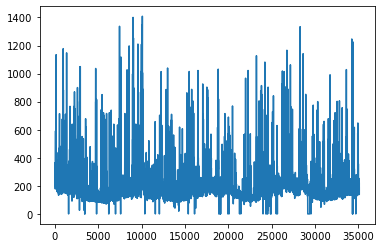

In [ ]:


plt.plot(output_sequences)
plt.fill_between(np.arange(len(output_sequences)),Y_pred + Y_pred_std,Y_pred - Y_pred_std,color='orange')
plt.plot()
plt.xlim(0,100)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(output_sequences)
plt.fill_between(np.arange(len(output_sequences)),Y_pred + Y_pred_std,Y_pred - Y_pred_std,color='orange')
plt.plot()
plt.xlim(1000,2000)
plt.show()



# Linear regression with extra variables

In [ ]:
input_sequences.shape

(35101, 1500, 4)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error

train_performance_dict = {}
test_performance_dict = {}
lag_values = np.arange(2,24*7,1)
for lag in lag_values:
    # print('Using lag: ',lag)
    input_sequences_subset,output_sequences_subset = input_sequences[:,-lag:].reshape(-1,lag*4),output_sequences
    # print(input_sequences_subset.shape)
    # input_sequences_subset,output_sequences_subset =\
    # get_x_y_with_lag(lag,
    #                  input_data = X,
    #                  output_data = Y,
    #                  dt_start = X.index.min(),
    #                  dt_end = datetime.datetime(2020,12,31,23,59,59))
    
    
    n_train = int(len(input_sequences_subset)*0.8)
    linreg = LinearRegression().fit(input_sequences_subset[:n_train], output_sequences_subset[:n_train])

    y_pred_train = linreg.predict(input_sequences_subset[:n_train]) 
    y_pred_test = linreg.predict(input_sequences_subset[n_train:]) 
    corr_func = lambda a,b : np.corrcoef(a,b)[0,1]
    corr_func.__name__ = 'Correlation'
    perf_list_train = {}
    perf_list_test = {}
    for metric in [mean_absolute_error,mean_squared_error,corr_func]:
        train_score = metric(output_sequences_subset[:n_train],y_pred_train)
        test_score = metric(output_sequences_subset[n_train:],y_pred_test)
        perf_list_train[metric.__name__] = train_score
        perf_list_test[metric.__name__] = test_score
        
    train_performance_dict[lag] = perf_list_train
    test_performance_dict[lag] = perf_list_test

In [ ]:
test_scores = pd.DataFrame(test_performance_dict).T
train_scores = pd.DataFrame(train_performance_dict).T
for col in test_scores.columns:
    plt.plot(test_scores.loc[:,col])
    plt.plot(train_scores.loc[:,col])
    plt.title(col)
    plt.legend(['Test','Train'])
    plt.show()

In [ ]:
lag = 2*168
input_sequences_subset,output_sequences_subset = input_sequences[:,-lag:].reshape(-1,lag*4),output_sequences
n_train = int(len(input_sequences_subset)*0.8)
linreg = LinearRegression().fit(input_sequences_subset[:n_train], output_sequences_subset[:n_train])

y_pred_train = linreg.predict(input_sequences_subset[:n_train]) 
y_pred_test = linreg.predict(input_sequences_subset[n_train:]) 
corr_func = lambda a,b : np.corrcoef(a,b)[0,1]
corr_func.__name__ = 'Correlation'
perf_list_train = {}
perf_list_test = {}
for metric in [mean_absolute_error,mean_squared_error,corr_func]:
    train_score = metric(output_sequences_subset[:n_train],y_pred_train)
    test_score = metric(output_sequences_subset[n_train:],y_pred_test)
    perf_list_train[metric.__name__] = train_score
    perf_list_test[metric.__name__] = test_score
print(perf_list_test,perf_list_train)

In [ ]:
val_ratio = 0.2
n_hidden = 10
lag = 24*7
# rainfall_input_sequences,output_sequences = get_x_y_with_lag(lag)

input = tf.keras.layers.Input((lag,1))
translate_0 = tf.keras.layers.Dense(1, activation='linear',use_bias=True)
states = tf.keras.layers.LSTM(n_hidden,
                            #   activation='linear',
                              return_sequences = True)
flatten = tf.keras.layers.Flatten()
output = tf.keras.layers.Dense(1, activation='linear',use_bias=True)


sequence = states(translate_0(input))
flat_seq = flatten(sequence)
final_output = output(flat_seq)
model = tf.keras.Model(input,final_output)

tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [ ]:
test_scores

# Using LSTMs for temporal relationships

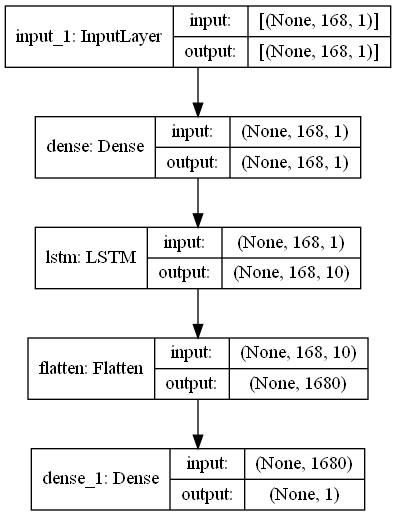

In [20]:

val_ratio = 0.2
n_hidden = 10
lag = 24*7
# rainfall_input_sequences,output_sequences = get_x_y_with_lag(lag)

input = tf.keras.layers.Input((lag,1))
translate_0 = tf.keras.layers.Dense(1, activation='linear',use_bias=True)
states = tf.keras.layers.LSTM(n_hidden,
                            #   activation='linear',
                              return_sequences = True)
flatten = tf.keras.layers.Flatten()
output = tf.keras.layers.Dense(1, activation='linear',use_bias=True)


sequence = states(translate_0(input))
flat_seq = flatten(sequence)
final_output = output(flat_seq)
model = tf.keras.Model(input,final_output)

tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

In [ ]:

optimizer = tf.optimizers.Adam(learning_rate=0.01) #, clipnorm = 0.01)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])


with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:,-1], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 10,
            shuffle=True,
            )

Epoch 1/10
1755/1755 [==============================] - 27s 13ms/step - loss: 10412.0596 - mean_absolute_error: 59.9492 - mean_squared_error: 10412.0596 - correlation: 0.4817 - val_loss: 7083.4487 - val_mean_absolute_error: 49.1048 - val_mean_squared_error: 7083.4487 - val_correlation: nan
Epoch 2/10
1755/1755 [==============================] - 24s 14ms/step - loss: 7874.4570 - mean_absolute_error: 54.6231 - mean_squared_error: 7874.4570 - correlation: 0.5677 - val_loss: 6416.8652 - val_mean_absolute_error: 50.8958 - val_mean_squared_error: 6416.8652 - val_correlation: nan
Epoch 3/10
1755/1755 [==============================] - 23s 13ms/step - loss: 7191.0581 - mean_absolute_error: 53.6440 - mean_squared_error: 7191.0581 - correlation: 0.5904 - val_loss: 5853.0176 - val_mean_absolute_error: 48.3960 - val_mean_squared_error: 5853.0176 - val_correlation: nan
Epoch 4/10
1755/1755 [==============================] - 23s 13ms/step - loss: 6798.9351 - mean_absolute_error: 52.8616 - mean_squar

# Using LSTMs with in addition to more weather data for potential hydrological modelling

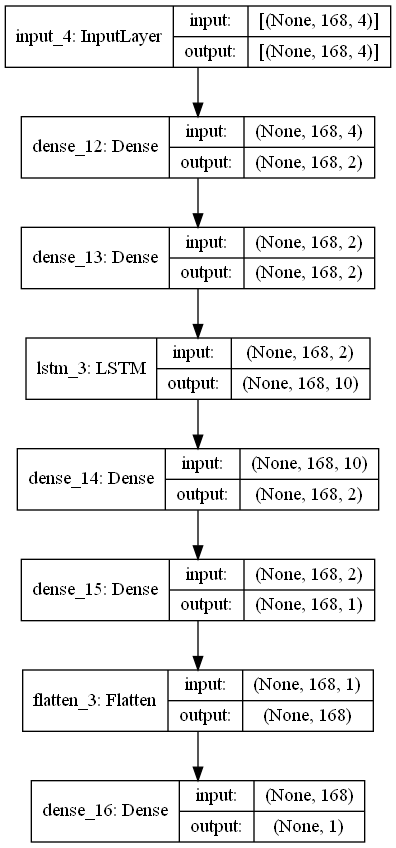

In [25]:
val_ratio = 0.2
n_hidden = 10
lag = 168
input = tf.keras.layers.Input((lag,input_sequences.shape[-1]))
translate_0 = tf.keras.layers.Dense(2, activation='relu')
translate_1 = tf.keras.layers.Dense(2, activation='relu')
states = tf.keras.layers.LSTM(n_hidden,
                            #   activation='linear',
                              return_sequences = True,
                              )
flatten = tf.keras.layers.Flatten()
retranslate_0 = tf.keras.layers.Dense(2, activation='relu')
retranslate_1 = tf.keras.layers.Dense(1, activation='relu')
# flatten = tf.keras.layers.Flatten()
output = tf.keras.layers.Dense(1, activation='linear')

model = tf.keras.Model(input,output(flatten(retranslate_1(retranslate_0(states(translate_1(translate_0(input))))))))

tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)


In [45]:
project = 'LSTM_training'
config = {
    'Dense_1': 2,
    'Dense_2': 2,
    'LSTM' : 10,
    'Dense_3': 2,
    'Dense_4': 1,
    'activation': 'relu',
    'name' : 'repeating best results model',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 20,
    'batch_size': 32,
    'lr' : 0.01,
    'lr_decay' : 0.9,
    'lag' : 168,
    'early_stopper_patience' : 20,
    'fold':0,
}
wandb.init(project=project,config=config)

# def refresh_wandb(fold = False):
#     if fold:
#         config['fold'] += 1
#     else:
#         config['fold'] = 0
#     wandb.init(project = project,
#                config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, 
                                                 patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(-2,-4,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)

def encoder_decoder_lstm():
    tf.random.set_seed(13) # bad seeds: 42, 55, 70, 77, 13
    val_ratio = 0.2
    n_hidden = 10
    lag = 168
    
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_1'],
                    activation=wandb.config['activation']
                    ))
    model.add(Dense(wandb.config['Dense_2'],
                    activation=wandb.config['activation']
                    ))
    model.add(LSTM(wandb.config['LSTM'],
                   return_sequences=True))
    
    model.add(Dense(wandb.config['Dense_3'],
                    activation=wandb.config['activation']
                    ))
    model.add(Dense(wandb.config['Dense_4'],
                    activation=wandb.config['activation']))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    
    optimizer = tf.optimizers.Adam(learning_rate=wandb.config['lr'])
    model.compile(optimizer=optimizer,
                loss=tf.losses.MSE,
                metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])


    return model

# tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)

# refresh_wandb()
with tf.device('/cpu:0'):
    history_dict_lstm, models_lstm, y_test_preds_lstm = evaluate_model(None,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        model_constructor = encoder_decoder_lstm,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
907/907 [==============================] - 27s 27ms/step - loss: 12444.5469 - mean_absolute_error: 61.4297 - mean_squared_error: 12444.5469 - correlation: 0.3786 - val_loss: 11566.6543 - val_mean_absolute_error: 56.9617 - val_mean_squared_error: 11566.6543 - val_correlation: 0.0536
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.007943282347242814.
907/907 [==============================] - 23s 26ms/step - loss: 10774.5156 - mean_absolute_error: 55.3082 - mean_squared_error: 10774.5156 - correlation: 0.4198 - val_loss: 11247.5820 - val_mean_absolute_error: 56.8483 - val_mean_squared_error: 11247.5820 - val_correlation: 0.0951
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.00630957344480193.
907/907 [==============================] - 23s 26ms/step - loss: 10650.2949 - mean_absolute_error: 54.7082 - mean_squared_error: 10650.2949 - correlation: 0.4330 - val_l

KeyboardInterrupt: 

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

The following Variables were used a Lambda layer's call (distribution_lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


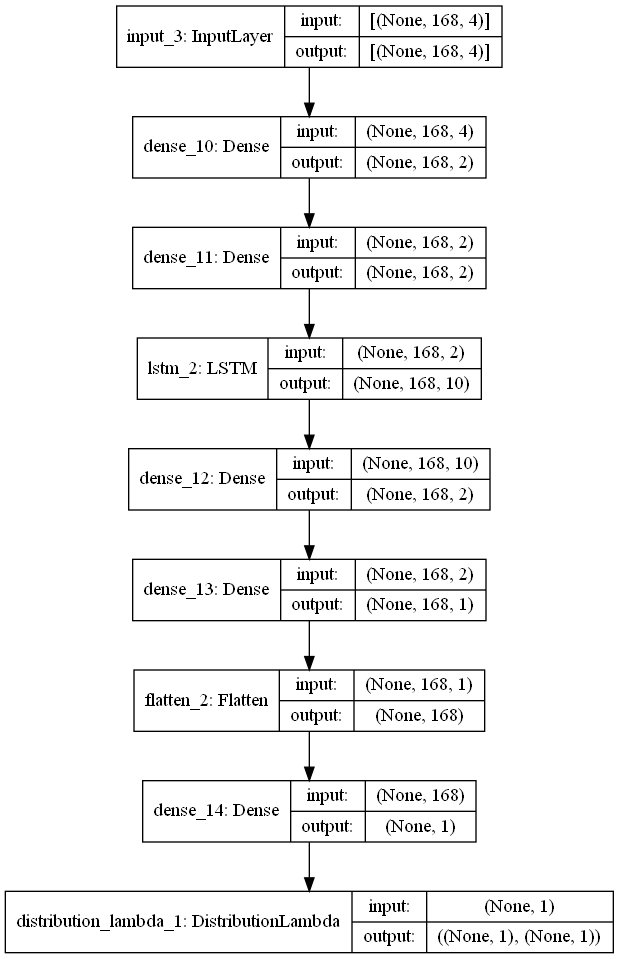

In [10]:
project = 'LSTM_training'
config = {
    'Dense_1': 2,
    'Dense_2': 2,
    'LSTM' : 10,
    'Dense_3': 2,
    'Dense_4': 1,
    'activation': 'relu',
    'name' : 'repeating best results model with probabalistic layers',
    'optimizer': 'Adam',
    'loss': 'Mean Squared Error',
    'metric': 'MAE',
    'epochs': 20,
    'batch_size': 32,
    'lr' : 0.01,
    'lr_decay' : 0.9,
    'lag' : 168,
    'early_stopper_patience' : 20,
    'fold':0,
}
wandb.init(project=project,config=config)

# def refresh_wandb(fold = False):
#     if fold:
#         config['fold'] += 1
#     else:
#         config['fold'] = 0
#     wandb.init(project = project,
#                config = config)



early_stopper = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, 
                                                 patience=wandb.config['early_stopper_patience'], verbose=0, mode='min', baseline=None, restore_best_weights=True,)
logging_callback = wandb.keras.WandbCallback(log_evaluation=False)
learning_rates = np.logspace(-2,-4,6*4-3)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch,lr : learning_rates[int(epoch/wandb.config['epochs'] * len(learning_rates))], verbose=1)

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

def encoder_decoder_lstm():
    tf.random.set_seed(99) 
    val_ratio = 0.2
    n_hidden = 10
    lag = 168
    
    scale = tf.Variable(1.)

        
    model = Sequential()
    model.add(Input((wandb.config['lag'],4)))
    model.add(Dense(wandb.config['Dense_1'],
                    activation=wandb.config['activation']
                    ))
    model.add(Dense(wandb.config['Dense_2'],
                    activation=wandb.config['activation']
                    ))
    
    model.add(LSTM(wandb.config['LSTM'],
                   return_sequences=True))
    
    model.add(Dense(wandb.config['Dense_3'],
                    activation=wandb.config['activation']
                    ))
    model.add(Dense(wandb.config['Dense_4'],
                    activation=wandb.config['activation']))
    
    model.add(Flatten())
    
    model.add(Dense(1,
                activation='linear'))
    
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=scale)))

    optimizer = tf.optimizers.Adam(learning_rate=wandb.config['lr'])
    
    model.compile(optimizer=optimizer,
                # loss=negloglik, 
                loss = tf.losses.MSE,
                metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation]
                )


    return model

tf.keras.utils.plot_model(encoder_decoder_lstm(),show_layer_names=True,show_shapes=True)

In [388]:
model = encoder_decoder_lstm()

# model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
# model.predict(np.arange(0,168*4).reshape((-1,168,4))) # 7.0451164
y_pred = model(input_sequences[:5,-lag:,[0,1,2,3]]) # 7.0451164
y_pred

The following Variables were used a Lambda layer's call (distribution_lambda_311), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


<tfp.distributions.Normal 'sequential_210_distribution_lambda_311_Normal' batch_shape=[5, 1] event_shape=[] dtype=float32>

In [389]:
# # Build model.
# model = tf.keras.Sequential([
#   tf.keras.layers.Dense(1 + 1),
#   tf.keras.layers.Dense(1 + 1),
#   tfp.layers.DistributionLambda(
#       lambda t: tfd.Normal(loc=t[..., :1],
#                            scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
# ])

# # Do inference.
# model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
# # model.fit(x, y, epochs=1000, verbose=False);

# # Profit.
# # [print(np.squeeze(w.numpy())) for w in model.weights];
# yhat = model(input_sequences[:,-150:,0])
# assert isinstance(yhat, tfd.Distribution)


# tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True)
# yhat

In [390]:
# refresh_wandb()
with tf.device('/cpu:0'):
    history_dict_lstm, models_lstm, y_test_preds_lstm = evaluate_model(model,
                                                                        params = [0,1,2,3],
                                                                        lag = wandb.config['lag'],
                                                                        squeeze = False,
                                                                        
                                                                        # model_constructor = encoder_decoder_lstm,
                                                                        specify_validation_data = True,
                                                                        folds = 5,
                                                                        # Kwargs
                                                                        batch_size = wandb.config['batch_size'],
                                                                        epochs = wandb.config['epochs'],
                                                                        shuffle=True,
                                                                        callbacks = [
                                                                            lr_scheduler,
                                                                            early_stopper,
                                                                            logging_callback
                                                                                    ],
                                                                        verbose = 1
                                                                        )

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
907/907 [==============================] - 29s 30ms/step - loss: 11696.3184 - mean_absolute_error: 59.0274 - mean_squared_error: 11696.3184 - correlation: 0.3718 - val_loss: 11486.8506 - val_mean_absolute_error: 58.9772 - val_mean_squared_error: 11486.8506 - val_correlation: 0.1619
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.007943282347242814.
907/907 [==============================] - 26s 29ms/step - loss: 10689.2686 - mean_absolute_error: 55.3576 - mean_squared_error: 10689.2686 - correlation: 0.4306 - val_loss: 11561.2266 - val_mean_absolute_error: 60.2218 - val_mean_squared_error: 11561.2266 - val_correlation: 0.1242
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.00630957344480193.
 94/907 [==>...........................] - ETA: 22s - loss: 9275.2480 - mean_absolute_error: 52.9449 - mean_squared_error: 9275.2480 - correlation: 0.4744

KeyboardInterrupt: 

In [ ]:
y_pred = model(input_sequences[:10000,-lag:,[0,1,2,3]]) # 7.0451164
plt.plot(output_sequences[:10000])
plt.plot(y_pred.sample())
plt.plot(y_pred.sample())
plt.plot(y_pred.sample())
y_pred.variance()

Error: Session cannot generate requests

# Simple conceptual model

In [335]:

from tensorflow.data import Dataset
def evaluate_model_2(model,
                     input_data,
                     output_data,
                     model_constructor = None,
                     fn_kfold = KFold,
                     folds = 5,
                     **kwargs):
    model_list = []
    history = {}
    y_test_preds = []
    kfold = fn_kfold(folds)
    
    for i,(train, test) in enumerate(kfold.split(output_data)):
        [print(inp[train].shape) for inp in input_data]
        X_train = [inp[train] for inp in input_data]
        X_test = [inp[test] for inp in input_data]
        Y_train = output_data[train]
        Y_test = output_data[test]

        fold_statistics = {}
        # If the model needs to be reconstructed
        if not isinstance(model_constructor,type(None)):
            model = model_constructor()
            
            model.fit(X_train,
                      Y_train,
                      validation_data = (X_test,
                                         output_data[test]),**kwargs)
        
        y_train_pred = model.predict(X_train).ravel()
        y_test_pred = model.predict(X_test).ravel()
        
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        
        fold_statistics['mse_train'] = tf.losses.MSE(Y_train,y_train_pred).numpy()
        fold_statistics['mse_test'] = tf.losses.MSE(Y_test,y_test_pred).numpy()
        fold_statistics['mae_train'] = tf.keras.metrics.MAE(Y_train,y_train_pred).numpy()
        fold_statistics['mae_test'] = tf.keras.metrics.MAE(Y_test,y_test_pred).numpy()
        
        model_list.append(model)
        
        history[i] = fold_statistics
        y_test_preds.append(y_test_pred)
    return (history,model_list,np.concatenate(y_test_preds).ravel())



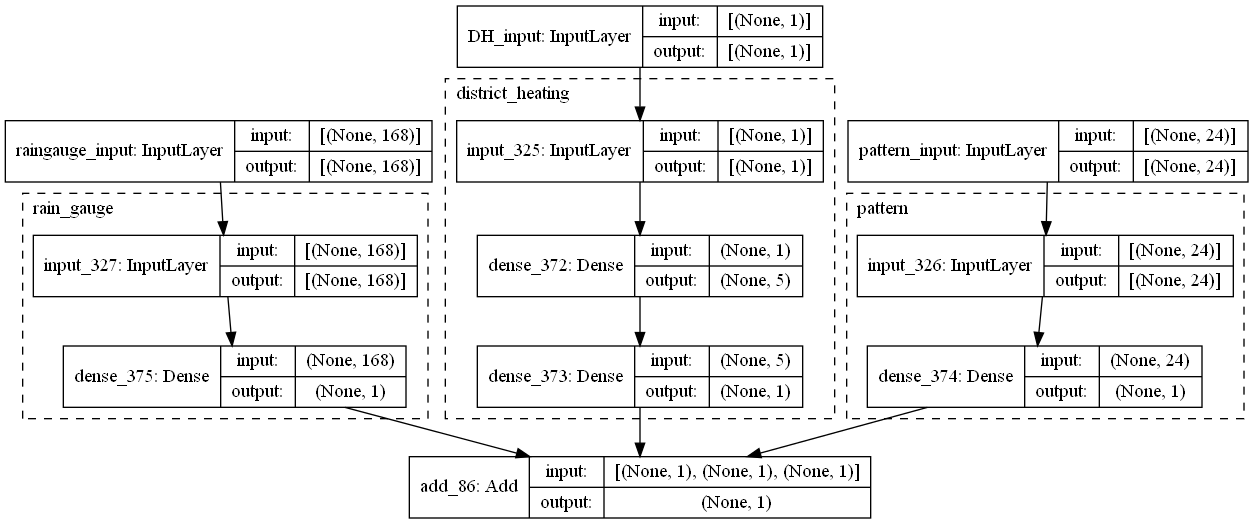

In [367]:
project = 'conceptual_model'
config = {
    'name': 'Simple conceptual model',

    'batch_size': 24,
    'epochs': 20,

    
    'loss': 'Mean Squared Error',
    
    'cross_validation':{
        'fn_kfold':'KFold',
        # 'fn_kfold':'TimeSeriesSplit',
        'folds':5
    },
    'district_heating': {
        'n_rolling_temperature':24,
        'dense_1': 5,
        'dense_2': 1,
        'activation_1': 'relu',
        'activation_2': 'relu',
    },
    
    'pattern': {
        'pattern_length': 24
    },
    
    'rainfall_runoff': {
        'lag': 168,
        'dense_1': 1,
        'activation_1': 'linear',
    },

    'learning_rate': {
        'inital_log': -2,
        'final_log': -4,
        'intervals': 100,
    },

    'optimizer': {'name': 'Adam',
                  'learning_rate': 0.01,
                  'decay': 0.0,
                  'beta_1': 0.9,
                  'beta_2': 0.999,
                  'epsilon': 1e-07,
                  'amsgrad': False},

    'early_stopper': {
        'monitor': 'val_loss',
        'min_delta': 0,
        'patience': 20,
        'verbose': 0,
        'mode': 'min',
        'baseline': None,
        'restore_best_weights': True,
    },

}
wandb.init(project=project, config=config)


def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor=wandb.config['early_stopper']['monitor'],
    min_delta=wandb.config['early_stopper']['min_delta'],
    patience=wandb.config['early_stopper']['patience'],
    verbose=wandb.config['early_stopper']['verbose'],
    mode=wandb.config['early_stopper']['mode'],
    baseline=wandb.config['early_stopper']['baseline'],
    restore_best_weights=wandb.config['early_stopper']['restore_best_weights']
)


def conceptual_model_simple():
    wandb.init(project=project, config=config)

    tf.random.set_seed(99)

    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((1,)),
        Dense(wandb.config['district_heating']['dense_1'],
              wandb.config['district_heating']['activation_1']),
        Dense(wandb.config['district_heating']['dense_2'],
              wandb.config['district_heating']['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input(wandb.config['pattern']['pattern_length']),
        Dense(1, activation='linear', use_bias=False)
    ],name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],)),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
    ],'rain_gauge')

    District_heating_input = Input((1,),name='DH_input')
    Daily_pattern_input = Input((wandb.config['pattern']['pattern_length'],),name='pattern_input')
    Rainfall_runoff_input = Input((wandb.config['rainfall_runoff']['lag'],),name='raingauge_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([District_heating_input,
                            Daily_pattern_input,
                            Rainfall_runoff_input],
                           combined_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(conceptual_model_simple(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [368]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

if wandb.config['pattern']['pattern_length'] == 24:
    hour_vector = pd.DatetimeIndex(date_sequences).hour.values
else:
    raise Exception('Todo later')

pattern_sequences = ohe.fit_transform(hour_vector.reshape(-1,1))
temperature_sequences = input_sequences[:,-wandb.config['district_heating']['n_rolling_temperature']:,0].sum(axis=1).reshape(-1,1)
rain_gauge_sequences = input_sequences[:,-wandb.config['rainfall_runoff']['lag']:,3]


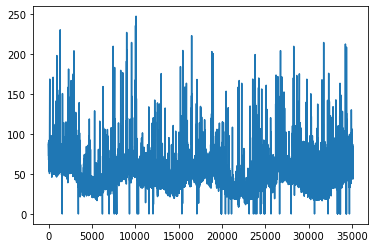

In [369]:
# refresh_wandb()
# with tf.device('/gpu:0'):
with tf.device('/cpu:0'):
    (history_dict_conceptual_simple,
     models_conceptual_simple,
     y_test_preds_conceptual_simple) =\
         evaluate_model_2(None,
                          input_data=[
                              temperature_sequences,
                              pattern_sequences.toarray(),
                              rain_gauge_sequences],
                          output_data = output_sequences,
                          model_constructor=conceptual_model_simple,
                          fn_kfold=getattr(
                              sklearn.model_selection, wandb.config['cross_validation']['fn_kfold']),
                          folds=wandb.config['cross_validation']['folds'],
                          
                          # Kwargs
                          batch_size=wandb.config['batch_size'],
                          epochs=wandb.config['epochs'],
                          shuffle=True,
                          callbacks=[
                              lr_scheduler,
                              early_stopper,
                              logging_callback
                              ],
                          verbose=1
                          )

(28080, 1)
(28080, 24)
(28080, 168)
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
1170/1170 [==============================] - 1s 805us/step - loss: 550.5326 - mean_absolute_error: 17.0540 - mean_squared_error: 550.5326 - correlation: 0.2875 - val_loss: 221.6838 - val_mean_absolute_error: 10.3710 - val_mean_squared_error: 221.6838 - val_correlation: 0.4602
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.007924828983539169.
 282/1170 [======>.......................] - ETA: 0s - loss: 240.1873 - mean_absolute_error: 10.5414 - mean_squared_error: 240.1873 - correlation: 0.6347

C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


1170/1170 [==============================] - 1s 633us/step - loss: 249.9463 - mean_absolute_error: 10.6872 - mean_squared_error: 249.9463 - correlation: 0.6346 - val_loss: 175.0507 - val_mean_absolute_error: 8.9312 - val_mean_squared_error: 175.0507 - val_correlation: 0.5483
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.006280291441834253.
1170/1170 [==============================] - 1s 639us/step - loss: 228.8570 - mean_absolute_error: 10.1356 - mean_squared_error: 228.8570 - correlation: 0.6602 - val_loss: 183.2857 - val_mean_absolute_error: 9.4407 - val_mean_squared_error: 183.2857 - val_correlation: 0.5727
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0049770235643321085.
1170/1170 [==============================] - 1s 701us/step - loss: 220.7420 - mean_absolute_error: 9.9300 - mean_squared_error: 220.7420 - correlation: 0.6714 - val_loss: 179.9581 - val_mean_absolute_error: 9.4318 - val_mean_squared_error: 179.9581 - val_corr

In [370]:
y_test_preds_conceptual_

NameError: name 'y_test_preds_conceptual_' is not defined

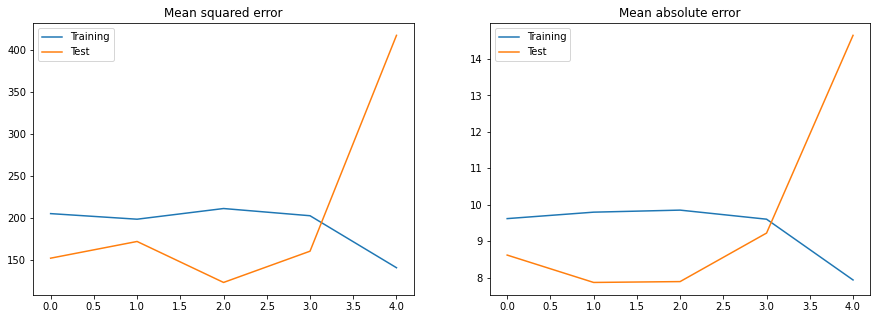

In [371]:
df_history_conceptual_simple = pd.DataFrame(history_dict_conceptual_simple).T
visualize_history_dict(df_history_conceptual_simple)

In [372]:
len(y_test_preds_conceptual_simple), len(output_sequences)

(35101, 35101)

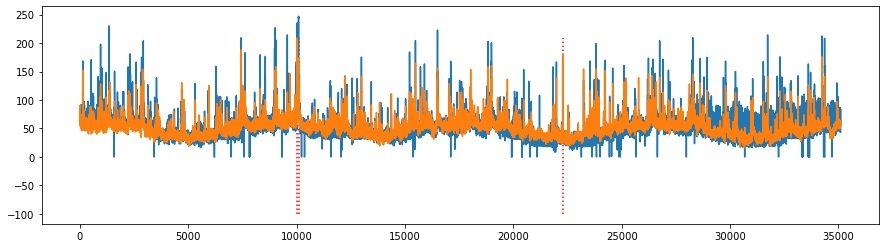

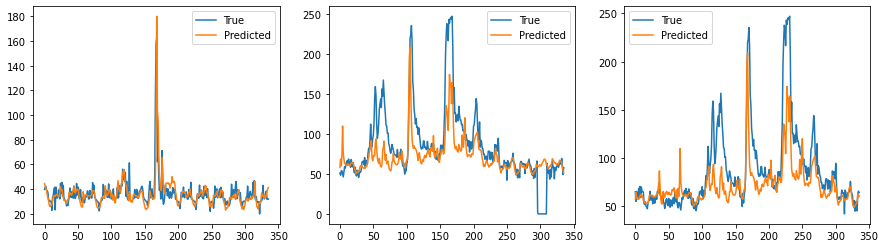

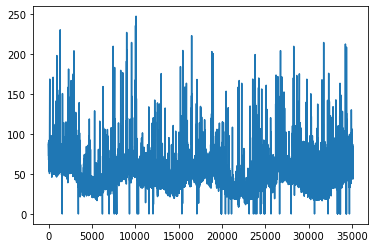

In [375]:
visualize_perforamnce_and_events(y_test_preds_conceptual_simple)
plt.plot(output_sequences)

# Conceptual model with recurrent rainfall-runoff

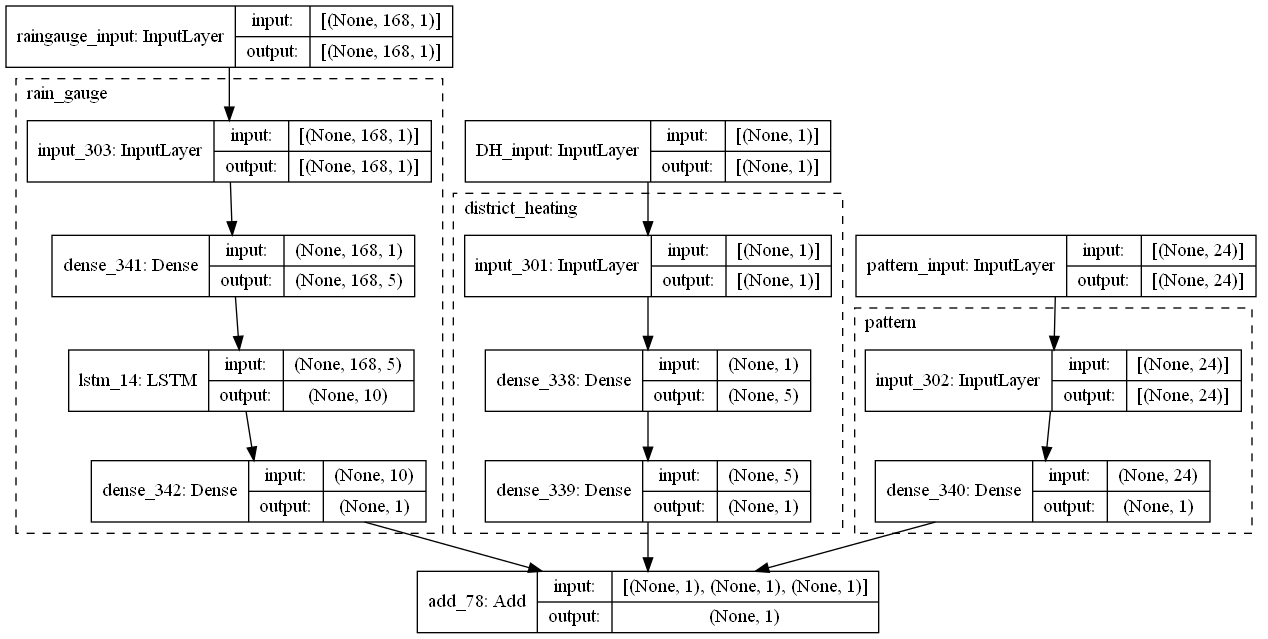

In [343]:
project = 'conceptual_model'
config = {
    'name': 'Conceptual model with recurrent rainfall-runoff',

    'batch_size': 24,
    'epochs': 20,

    
    'loss': 'Mean Squared Error',
    
    'cross_validation':{
        'fn_kfold':'KFold',
        # 'fn_kfold':'TimeSeriesSplit',
        'folds':5
    },
    'district_heating': {
        'n_rolling_temperature':24,
        'dense_1': 5,
        'dense_2': 1,
        'activation_1': 'relu',
        'activation_2': 'relu',
    },
    
    'pattern': {
        'pattern_length': 24
    },
    
    'rainfall_runoff': {
        'lag': 168,
        'dense_1': 5,
        'activation_1': 'relu',
        'lstm': 10,
        'dense_2': 1,
        'activation_2': 'relu',
    },

    'learning_rate': {
        'inital_log': -2,
        'final_log': -4,
        'intervals': 100,
    },

    'optimizer': {'name': 'Adam',
                  'learning_rate': 0.01,
                  'decay': 0.0,
                  'beta_1': 0.9,
                  'beta_2': 0.999,
                  'epsilon': 1e-07,
                  'amsgrad': False},

    'early_stopper': {
        'monitor': 'val_loss',
        'min_delta': 0,
        'patience': 20,
        'verbose': 0,
        'mode': 'min',
        'baseline': None,
        'restore_best_weights': True,
    },

}
wandb.init(project=project, config=config)


def lr_schedule(epoch, lr):
    learning_rates = np.logspace(wandb.config['learning_rate']['inital_log'],
                                 wandb.config['learning_rate']['final_log'],
                                 wandb.config['learning_rate']['intervals'])
    epochs = wandb.config['epochs']
    n_lr = wandb.config['learning_rate']['intervals']

    return learning_rates[int(epoch/epochs * n_lr)]


logging_callback = wandb.keras.WandbCallback(log_evaluation=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor=wandb.config['early_stopper']['monitor'],
    min_delta=wandb.config['early_stopper']['min_delta'],
    patience=wandb.config['early_stopper']['patience'],
    verbose=wandb.config['early_stopper']['verbose'],
    mode=wandb.config['early_stopper']['mode'],
    baseline=wandb.config['early_stopper']['baseline'],
    restore_best_weights=wandb.config['early_stopper']['restore_best_weights']
)


def conceptual_model_recurrent():
    wandb.init(project=project, config=config)

    tf.random.set_seed(99)

    # District heating - only input: 24 hour rolling average of temperature
    District_heating = Sequential([
        Input((1,)),
        Dense(wandb.config['district_heating']['dense_1'],
              wandb.config['district_heating']['activation_1']),
        Dense(wandb.config['district_heating']['dense_2'],
              wandb.config['district_heating']['activation_2']),
    ], name='district_heating')

    # Daily pattern (One-hot-encoded)
    Daily_pattern = Sequential([
        Input(wandb.config['pattern']['pattern_length']),
        Dense(1, activation='linear', use_bias=False)
    ],name='pattern')

    # Rainfall runoff only input: rain-gauge
    Rainfall_runoff = Sequential([
        Input((wandb.config['rainfall_runoff']['lag'],1)),
        Dense(wandb.config['rainfall_runoff']['dense_1'],
              wandb.config['rainfall_runoff']['activation_1']),
        LSTM(wandb.config['rainfall_runoff']['lstm']),
        Dense(wandb.config['rainfall_runoff']['dense_2'],
              wandb.config['rainfall_runoff']['activation_2']),
    ],'rain_gauge')

    District_heating_input = Input((1,),name='DH_input')
    Daily_pattern_input = Input((wandb.config['pattern']['pattern_length'],),name='pattern_input')
    Rainfall_runoff_input = Input((wandb.config['rainfall_runoff']['lag'],1),name='raingauge_input')

    District_heating_output = District_heating(District_heating_input)
    Daily_pattern_output = Daily_pattern(Daily_pattern_input)
    Rainfall_runoff_output = Rainfall_runoff(Rainfall_runoff_input)

    combined_output = tf.keras.layers.add(
        [Rainfall_runoff_output, District_heating_output, Daily_pattern_output])

    model = tf.keras.Model([District_heating_input,
                            Daily_pattern_input,
                            Rainfall_runoff_input],
                           combined_output)

    tf.keras.optimizers.get('Adam')

    optimizer = tf.keras.optimizers.get(
        {"class_name": wandb.config['optimizer']['name'],
         "config": wandb.config['optimizer']})

    model.compile(optimizer=optimizer,
                  loss=tf.losses.MSE,
                  metrics=[tf.keras.metrics.MAE,
                           tf.losses.MSE, tfp.stats.correlation]
                  )

    return model


tf.keras.utils.plot_model(conceptual_model_recurrent(),
                          show_layer_names=True,
                          show_shapes=True,
                          expand_nested=True)


In [344]:
# rain_gauge_sequences.shape

In [345]:
# refresh_wandb()
with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    (history_dict_conceptual_recurrent,
     models_conceptual_recurrent,
     y_test_preds_conceptual_recurrent) =\
         evaluate_model_2(None,
                          input_data=[
                              temperature_sequences,
                              pattern_sequences.toarray(),
                              rain_gauge_sequences.reshape(-1,168,1)],
                          output_data = output_sequences,
                          model_constructor=conceptual_model_recurrent,
                          fn_kfold=getattr(
                              sklearn.model_selection, wandb.config['cross_validation']['fn_kfold']),
                          folds=wandb.config['cross_validation']['folds'],
                          
                          # Kwargs
                          batch_size=wandb.config['batch_size'],
                          epochs=wandb.config['epochs'],
                          shuffle=True,
                          callbacks=[
                              lr_scheduler,
                              early_stopper,
                              logging_callback
                              ],
                          verbose=1
                          )

(28080, 1)
(28080, 24)
(28080, 168, 1)
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
1170/1170 [==============================] - 19s 15ms/step - loss: 791.0538 - mean_absolute_error: 20.5011 - mean_squared_error: 791.0538 - correlation: -0.0340 - val_loss: 293.2263 - val_mean_absolute_error: 10.5045 - val_mean_squared_error: 293.2263 - val_correlation: 0.3468
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.007924828983539169.
   9/1170 [..............................] - ETA: 18s - loss: 270.5179 - mean_absolute_error: 10.9492 - mean_squared_error: 270.5179 - correlation: 0.4824

C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


1170/1170 [==============================] - 17s 14ms/step - loss: 357.6029 - mean_absolute_error: 12.4213 - mean_squared_error: 357.6029 - correlation: 0.4468 - val_loss: 263.6786 - val_mean_absolute_error: 10.3475 - val_mean_squared_error: 263.6786 - val_correlation: 0.4438
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.006280291441834253.
1170/1170 [==============================] - 17s 14ms/step - loss: 346.9106 - mean_absolute_error: 12.1259 - mean_squared_error: 346.9106 - correlation: 0.4703 - val_loss: 294.3909 - val_mean_absolute_error: 10.4373 - val_mean_squared_error: 294.3909 - val_correlation: 0.4470
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0049770235643321085.
1170/1170 [==============================] - 16s 14ms/step - loss: 341.2896 - mean_absolute_error: 11.9496 - mean_squared_error: 341.2896 - correlation: 0.4797 - val_loss: 272.6944 - val_mean_absolute_error: 9.8590 - val_mean_squared_error: 272.6944 - val_c

KeyboardInterrupt: 

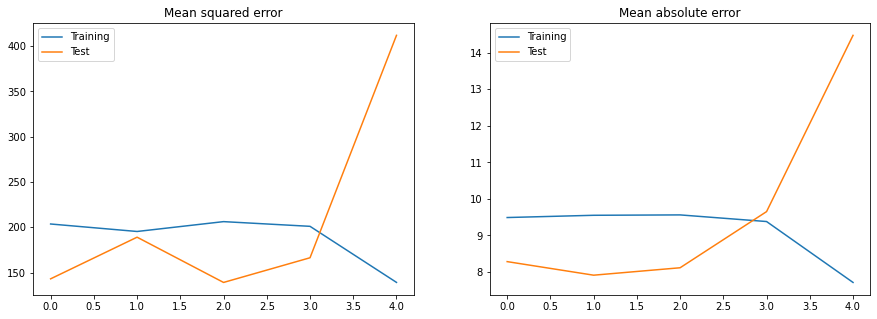

In [341]:
df_history_conceptual_recurrent = pd.DataFrame(history_dict_conceptual_recurrent).T
visualize_history_dict(df_history_conceptual_recurrent)

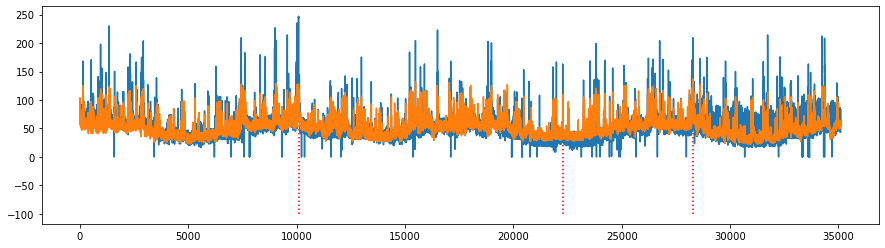

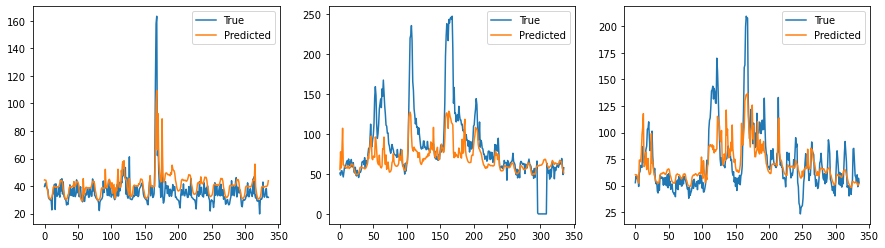

In [355]:
visualize_perforamnce_and_events(y_test_preds_conceptual_recurrent)

# Don't touch what is below

# Don't touch what is below

# Don't touch what is below

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.01) #, clipnorm = 0.01)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])


with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 10,
            shuffle=True,
            )

Epoch 1/10
1755/1755 [==============================] - 32s 16ms/step - loss: 11259.1592 - mean_absolute_error: 57.9263 - mean_squared_error: 11259.1592 - correlation: 0.4776 - val_loss: 11223.9453 - val_mean_absolute_error: 54.1043 - val_mean_squared_error: 11223.9453 - val_correlation: nan
Epoch 2/10
1755/1755 [==============================] - 24s 14ms/step - loss: 10438.7393 - mean_absolute_error: 54.7433 - mean_squared_error: 10438.7393 - correlation: 0.5255 - val_loss: 10563.6318 - val_mean_absolute_error: 52.2812 - val_mean_squared_error: 10563.6318 - val_correlation: nan
Epoch 3/10
1755/1755 [==============================] - 21s 12ms/step - loss: 8439.0625 - mean_absolute_error: 51.4867 - mean_squared_error: 8439.0625 - correlation: 0.6273 - val_loss: 8134.3462 - val_mean_absolute_error: 50.9044 - val_mean_squared_error: 8134.3462 - val_correlation: nan
Epoch 4/10
1755/1755 [==============================] - 23s 13ms/step - loss: 6132.4258 - mean_absolute_error: 46.6198 - mean

In [ ]:

optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])

with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 5,
            shuffle=True,
            )

Epoch 1/5
1755/1755 [==============================] - 27s 14ms/step - loss: 5190.4229 - mean_absolute_error: 44.4317 - mean_squared_error: 5190.4229 - correlation: 0.6902 - val_loss: 5429.1313 - val_mean_absolute_error: 42.5812 - val_mean_squared_error: 5429.1313 - val_correlation: nan
Epoch 2/5
1755/1755 [==============================] - 23s 13ms/step - loss: 4107.9946 - mean_absolute_error: 39.1785 - mean_squared_error: 4107.9946 - correlation: 0.7568 - val_loss: 3975.3423 - val_mean_absolute_error: 38.0471 - val_mean_squared_error: 3975.3423 - val_correlation: nan
Epoch 3/5
1755/1755 [==============================] - 22s 13ms/step - loss: 3913.5334 - mean_absolute_error: 38.6908 - mean_squared_error: 3913.5334 - correlation: 0.7673 - val_loss: 3742.0952 - val_mean_absolute_error: 37.8542 - val_mean_squared_error: 3742.0952 - val_correlation: nan
Epoch 4/5
1755/1755 [==============================] - 24s 14ms/step - loss: 3864.4607 - mean_absolute_error: 38.5361 - mean_squared_err

In [ ]:

optimizer = tf.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss=tf.losses.MSE,
              metrics=[tf.keras.metrics.MAE,tf.losses.MSE,tfp.stats.correlation])

with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    model.fit(input_sequences[:,-lag:], output_sequences,
            validation_split = val_ratio,
            batch_size = 16,
            epochs = 10,
            shuffle=True,
            )

Epoch 1/10
1755/1755 [==============================] - 25s 13ms/step - loss: 3740.5044 - mean_absolute_error: 38.0661 - mean_squared_error: 3740.5044 - correlation: 0.7730 - val_loss: 4098.9873 - val_mean_absolute_error: 38.9018 - val_mean_squared_error: 4098.9873 - val_correlation: nan
Epoch 2/10
1755/1755 [==============================] - 22s 13ms/step - loss: 3732.9885 - mean_absolute_error: 38.0008 - mean_squared_error: 3732.9885 - correlation: 0.7702 - val_loss: 3740.5486 - val_mean_absolute_error: 37.4907 - val_mean_squared_error: 3740.5486 - val_correlation: nan
Epoch 3/10
1755/1755 [==============================] - 22s 12ms/step - loss: 3713.0164 - mean_absolute_error: 37.9247 - mean_squared_error: 3713.0164 - correlation: 0.7734 - val_loss: 3790.2888 - val_mean_absolute_error: 37.7491 - val_mean_squared_error: 3790.2888 - val_correlation: nan
Epoch 4/10
1755/1755 [==============================] - 24s 14ms/step - loss: 3672.7405 - mean_absolute_error: 37.7601 - mean_squared

In [ ]:
n_train08 = int(len(output_sequences) * 0.8)
y_pred = model.predict(input_sequences[n_train08:,-lag:,])

In [35]:
plt.plot(output_sequences[n_train08:])
plt.plot(y_pred)

NameError: name 'n_train08' is not defined